## Import your stuff

In [1]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d

import matplotlib
%matplotlib inline

import time
import importlib

print("CCL version you are using:",ccl.__version__)

CCL version you are using: 2.1.0


In [3]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

In [4]:
import simulators.mass_function_n_counts.simulator_trapz_andrinas_edit_2params as n_counts_simulator
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_andrinas_edit_2params' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_andrinas_edit_2params.py'>

## Set up priors on params of interest (for now): {$\Omega_{m}h^{2} = \Omega_{cdm}h^{2} + \Omega_{b}h^{2}$, $\sigma_{8}$, $h$, $n_{s}$, $w_{0}$}

In [5]:
lower = np.array([0.1125, 0.6])
upper = np.array([0.1275, 1.1])
prior = priors.Uniform(lower, upper)

In [6]:
theta_fiducial = np.array([0.1197, 0.76])


## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [9]:
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_andrinas_edit_2params' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_andrinas_edit_2params.py'>

In [10]:
N_countsSimulator = n_counts_simulator.Model()

In [11]:
N_countsSimulator.N_counts

array([1.78485558e+04, 5.76970955e+04, 7.91959673e+04, 7.60280551e+04,
       5.88513395e+04, 2.53149917e+03, 6.50857065e+03, 6.79905624e+03,
       4.77690342e+03, 2.60821304e+03, 1.41326957e+02, 2.40973379e+02,
       1.54407659e+02, 6.19686706e+01, 1.80224732e+01])

In [12]:
log10masses = np.linspace(14, 16, num = 5)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)
log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))

In [13]:
N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_fiducial)

array([1.78485558e+04, 5.76970955e+04, 7.91959673e+04, 7.60280551e+04,
       5.88513395e+04, 2.53149917e+03, 6.50857065e+03, 6.79905624e+03,
       4.77690342e+03, 2.60821304e+03, 1.41326957e+02, 2.40973379e+02,
       1.54407659e+02, 6.19686706e+01, 1.80224732e+01, 1.15792928e+00,
       8.97137339e-01, 2.22002922e-01, 2.95445872e-02, 2.45078214e-03])

## For 1 mass bin (14 to 14.5)

In [16]:
cosmo_ccl = N_countsSimulator.cosmo(theta_fiducial)

In [17]:
log10masses = np.linspace(14., 14.5, num = 2)
z_min = np.array([0.1])
z_max = np.array([0.2])

n_steps_masses = 1000
n_steps_z = 100

log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))

In [18]:
N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_fiducial)

array([17848.55576403])

## For 2 mass bins (14 to 14.5 and 14.5 to 15) and the same redshift bin

In [21]:
log10masses = np.linspace(14., 15.5, num = 4)
log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))

In [22]:
N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_fiducial)

array([17848.55576403,  2531.49916637,   141.32695659])

## Set up simulator

In [23]:
def simulator(theta, seed, simulator_args, batch):
    return N_countsSimulator.simulation(theta, seed)

simulator_args = None

## Set up fake compressor for now

In [24]:
def compressor(data, compressor_args):
    return data
compressor_args=None

## Load data

In [25]:
#N_counts_data = np.load('N_counts_random_data.npy')
N_counts_data =  N_countsSimulator.simulation(theta_fiducial, 1)
N_counts_data

array([17817, 57410, 78913, 75947, 58796,  2484,  6490,  6697,  4739,
        2676,   121,   224,   135,    81,    20])

In [26]:
n_params = len(theta_fiducial)
print(n_params)
n_data_points = len(N_counts_data)
print(n_data_points)

2
15


## Define ensemble of NDEs

In [27]:
NDEs1 = [ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=0),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
       ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=n_params, n_data=n_data_points, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=5)]

## Create DELFI object

In [31]:
DelfiEnsemble = delfi.Delfi(N_counts_data, prior, NDEs1, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                            results_dir = "simulators/mass_function_n_counts/results_andrinas_edit_2params_1000sims/")

## Sequential Neural Likelihood

In [32]:
n_initial = 100 
n_batch = 100 
n_populations = 10 

Sampling approximate posterior...
Done.
Removed no burn in


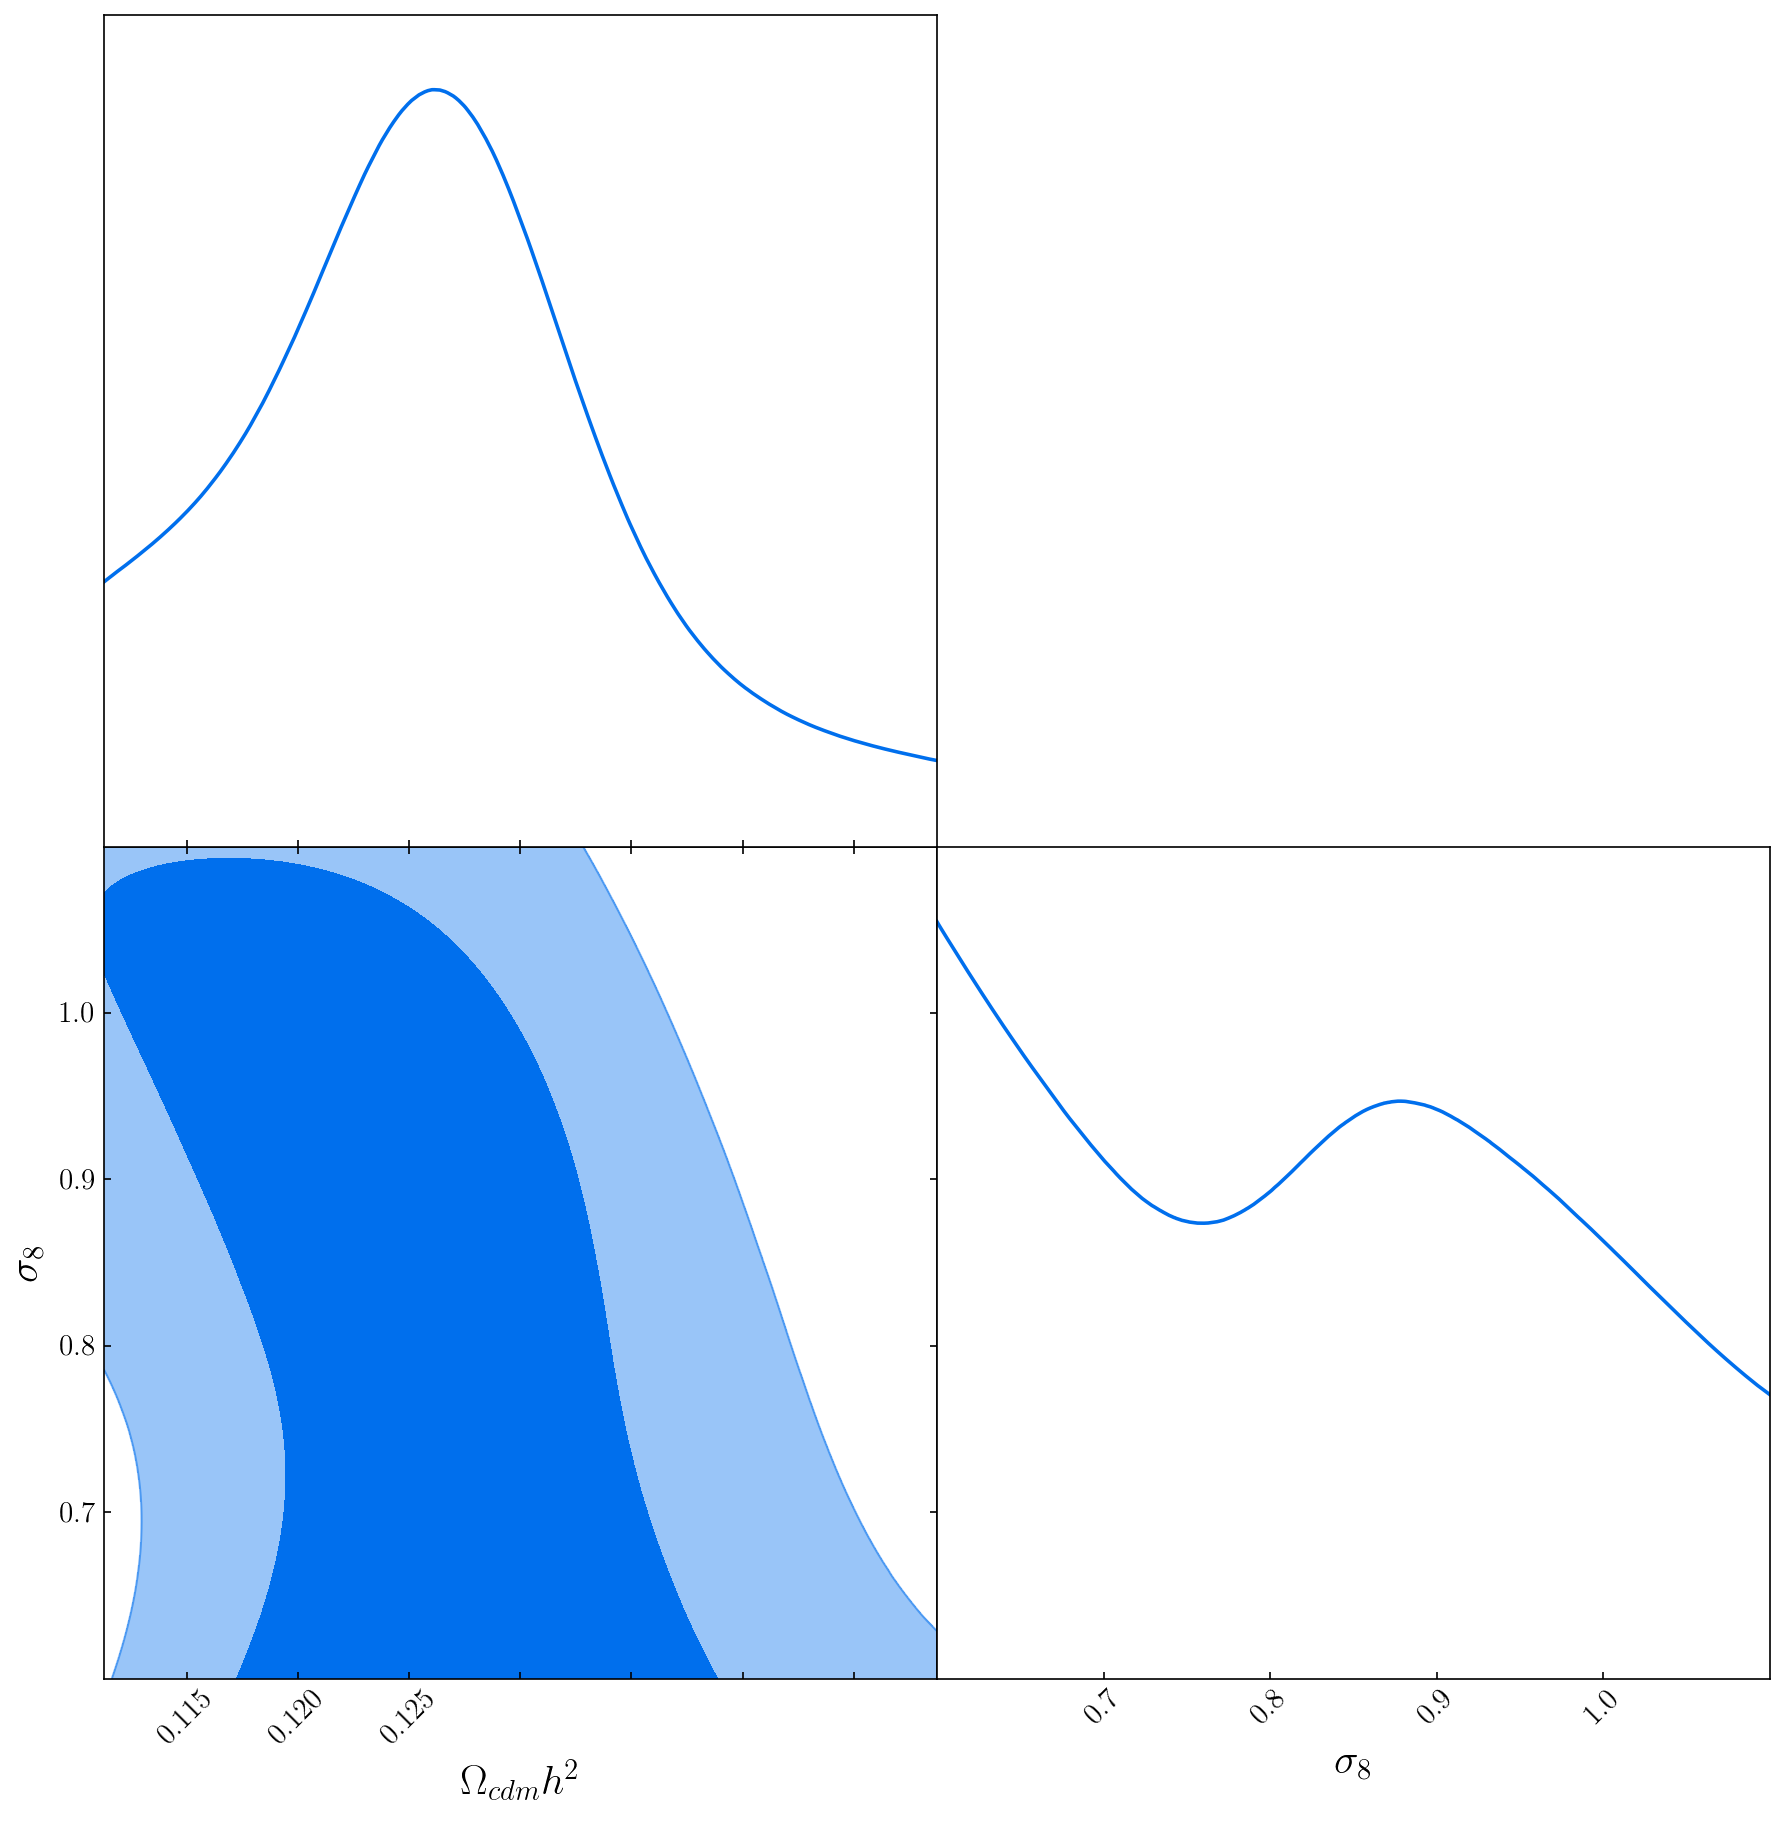

Population 1/10
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


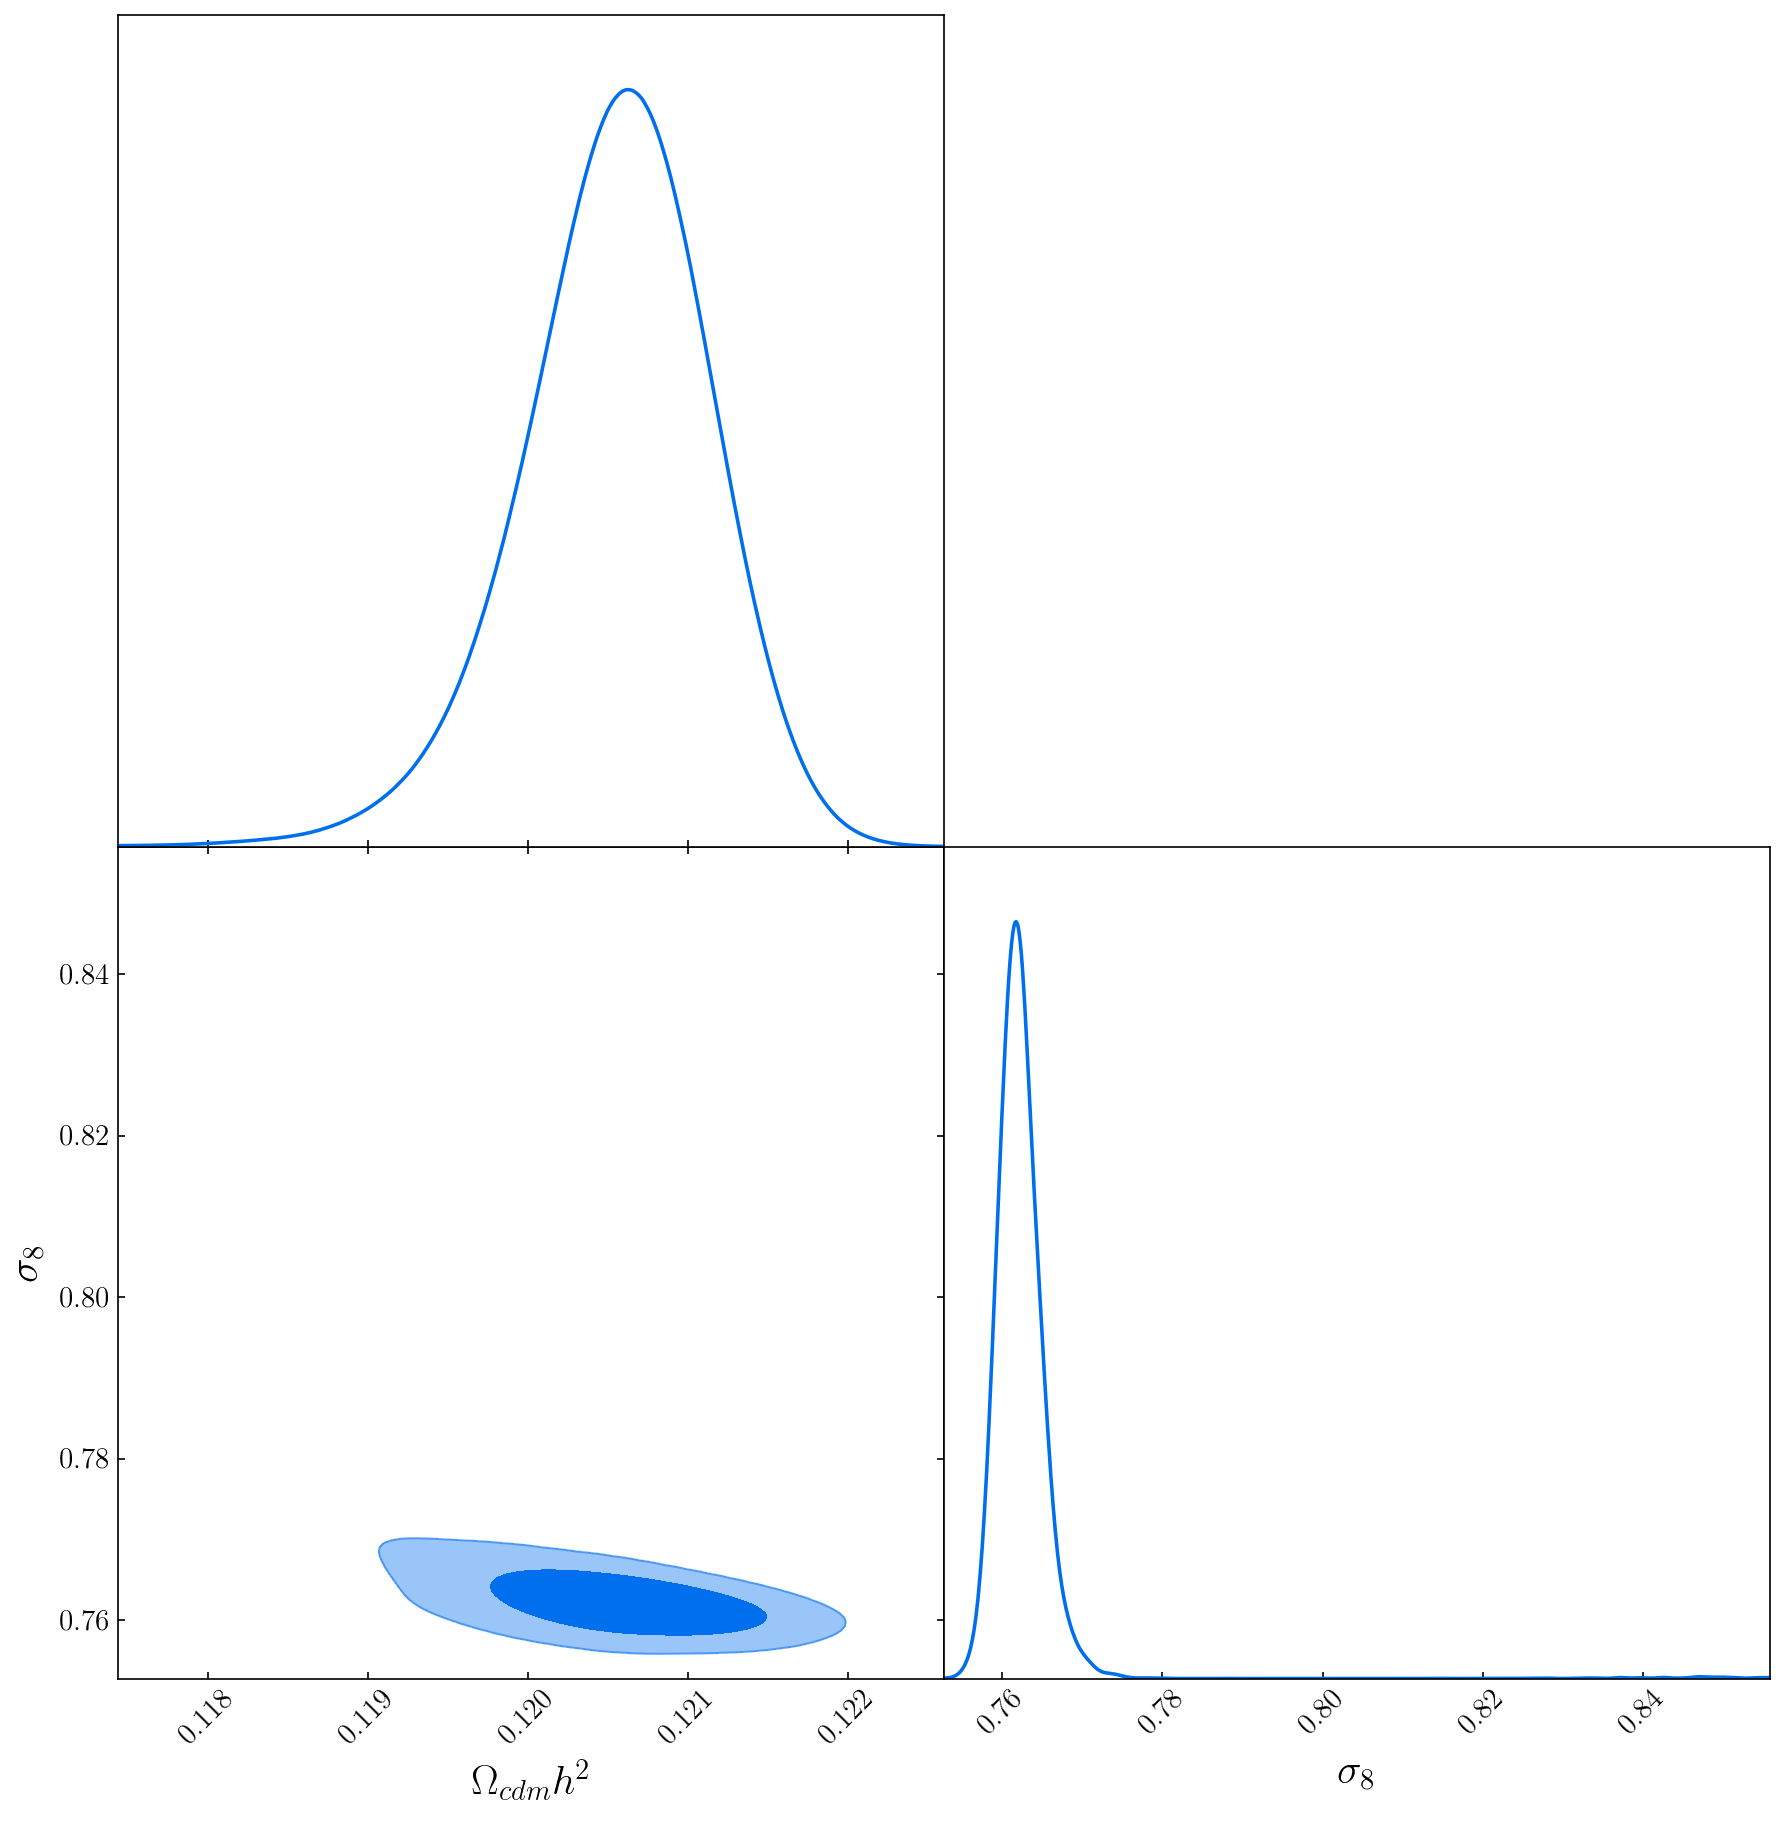

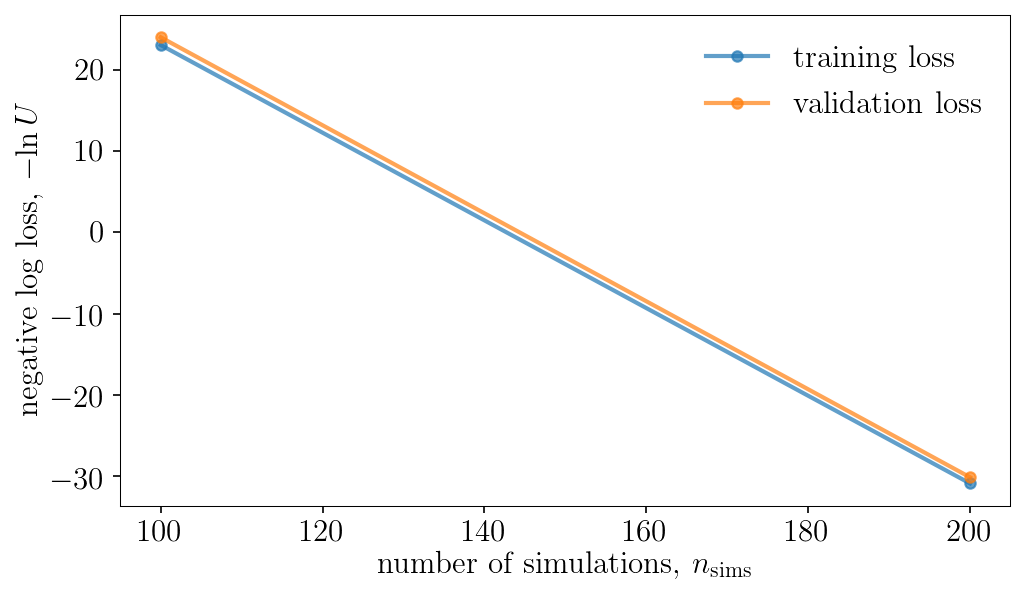

Population 2/10
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


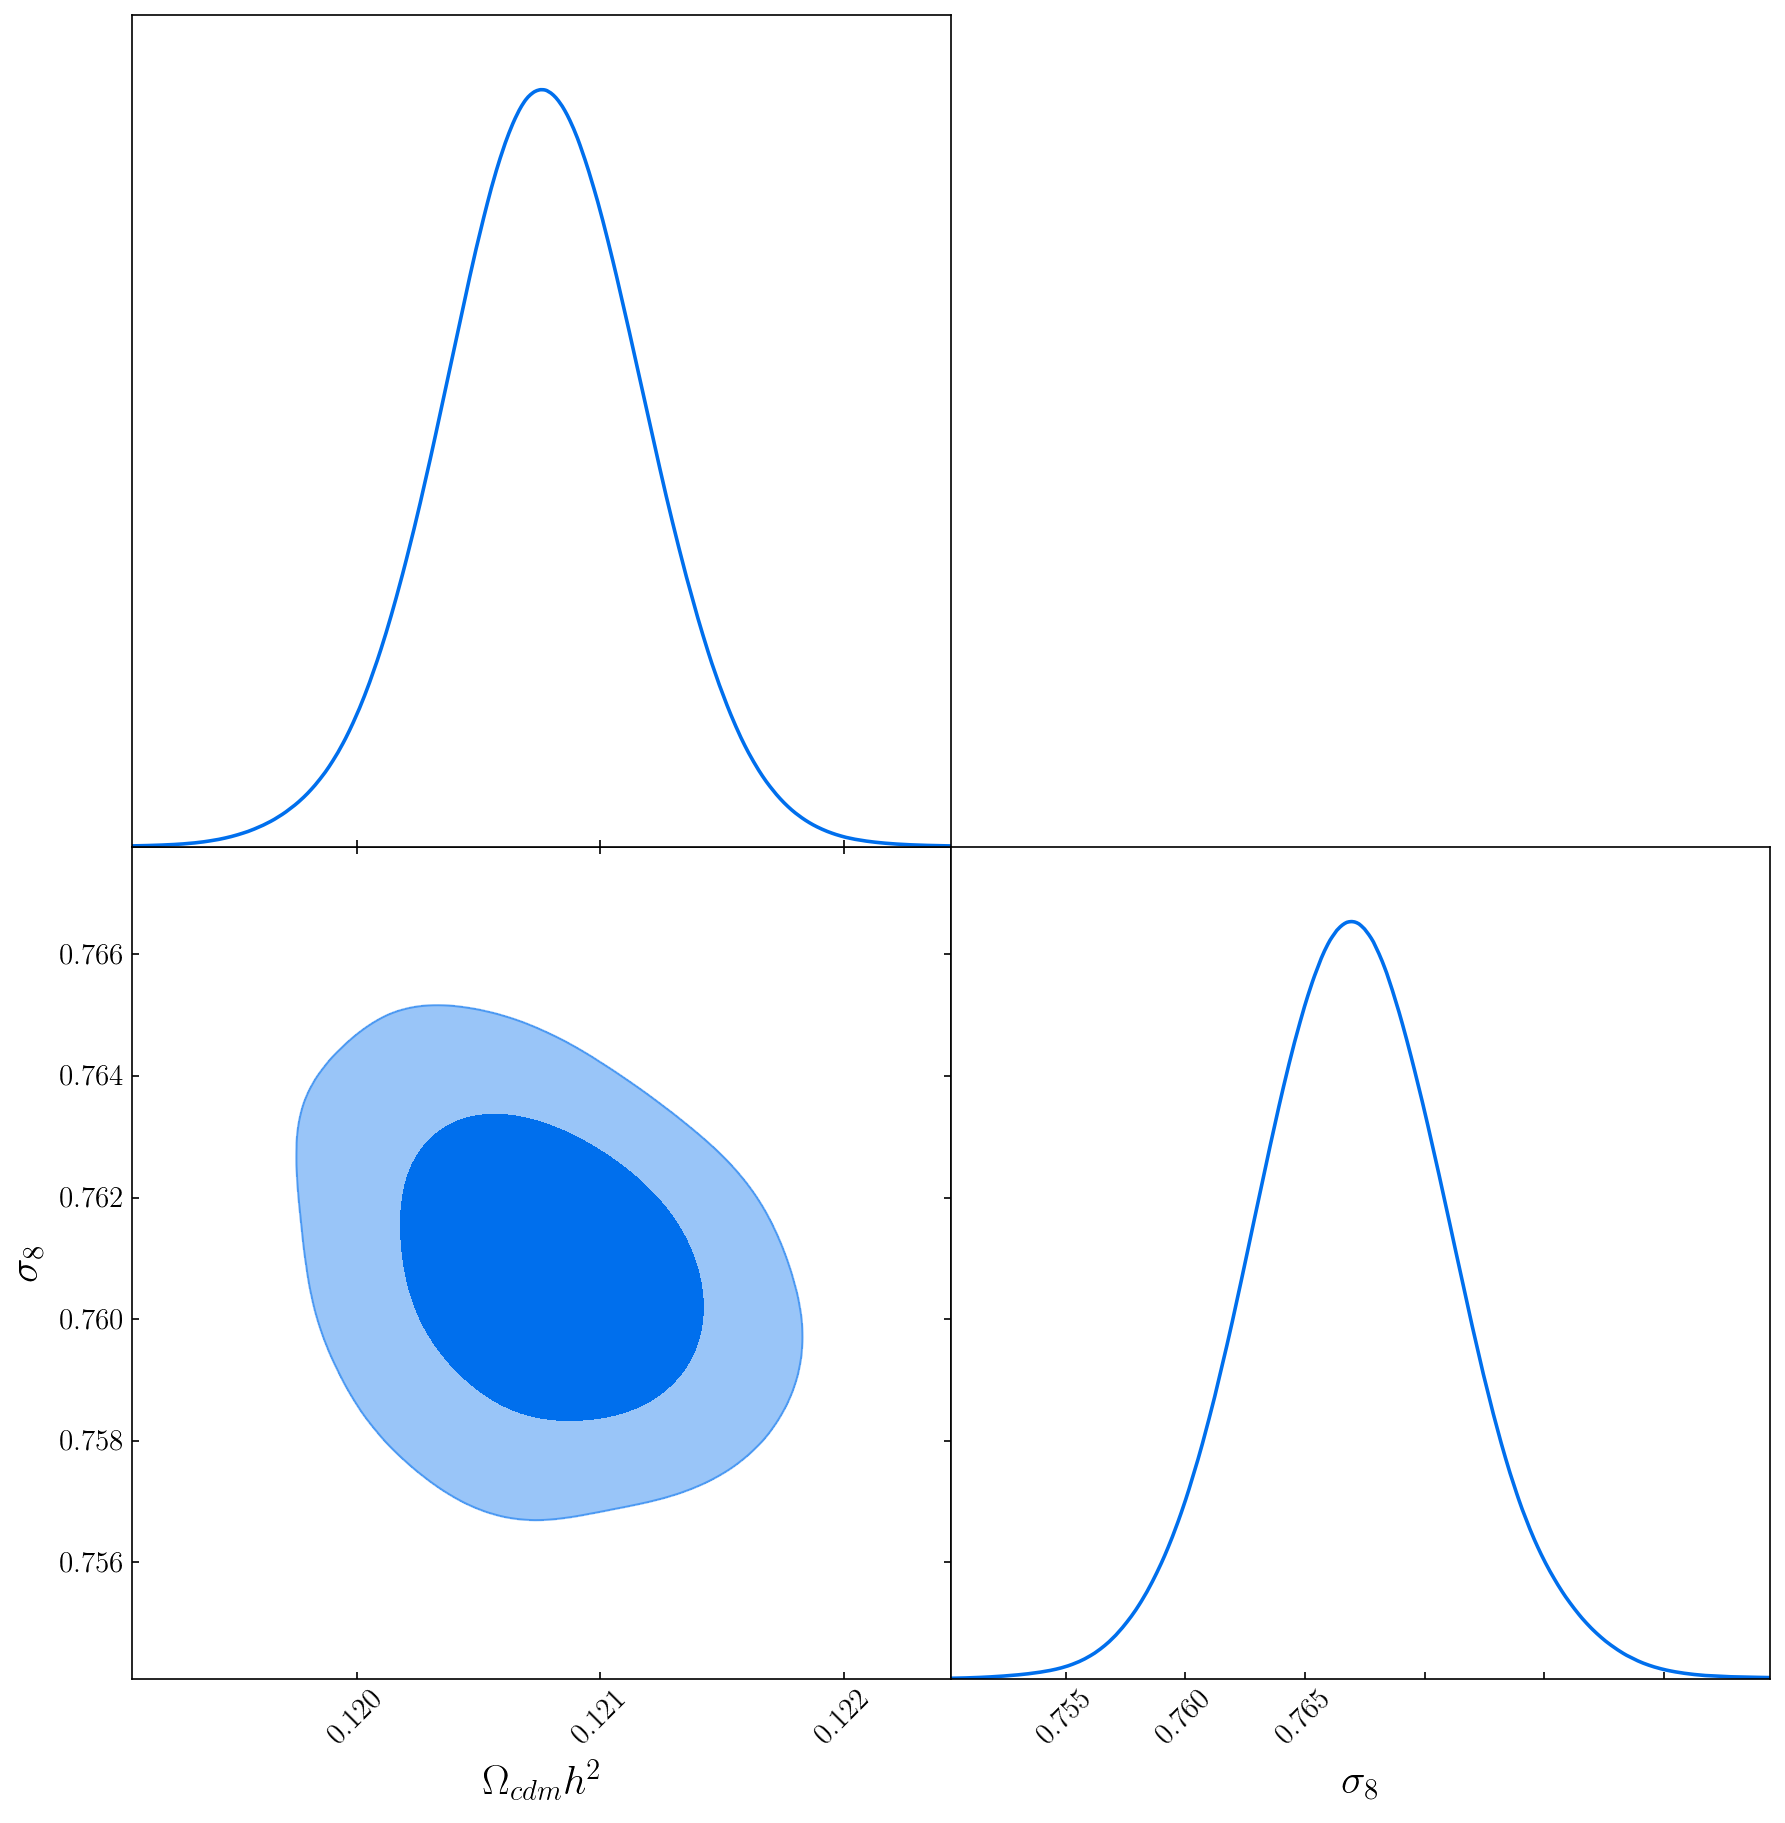

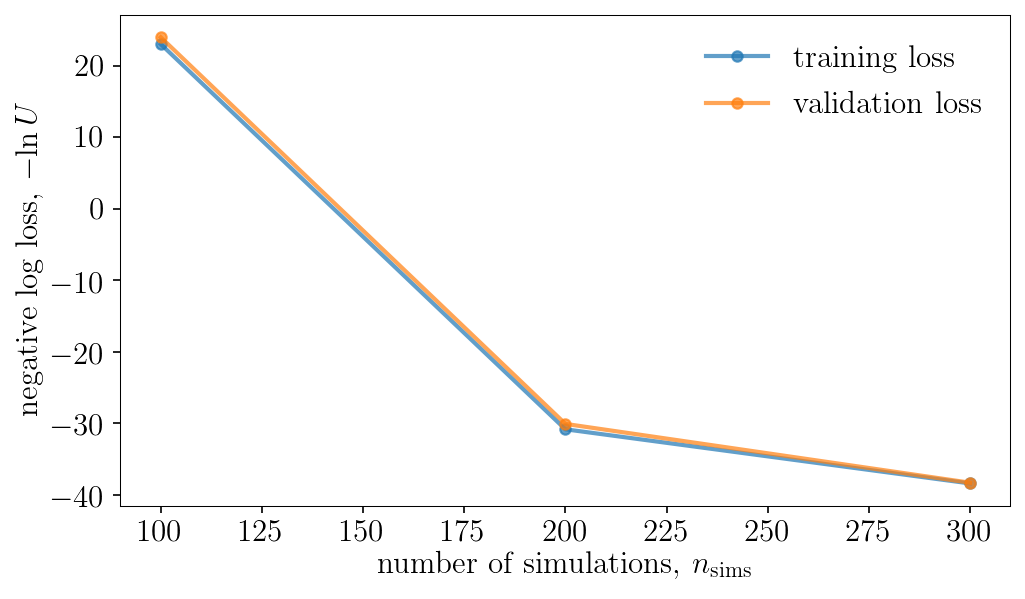

Population 3/10
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


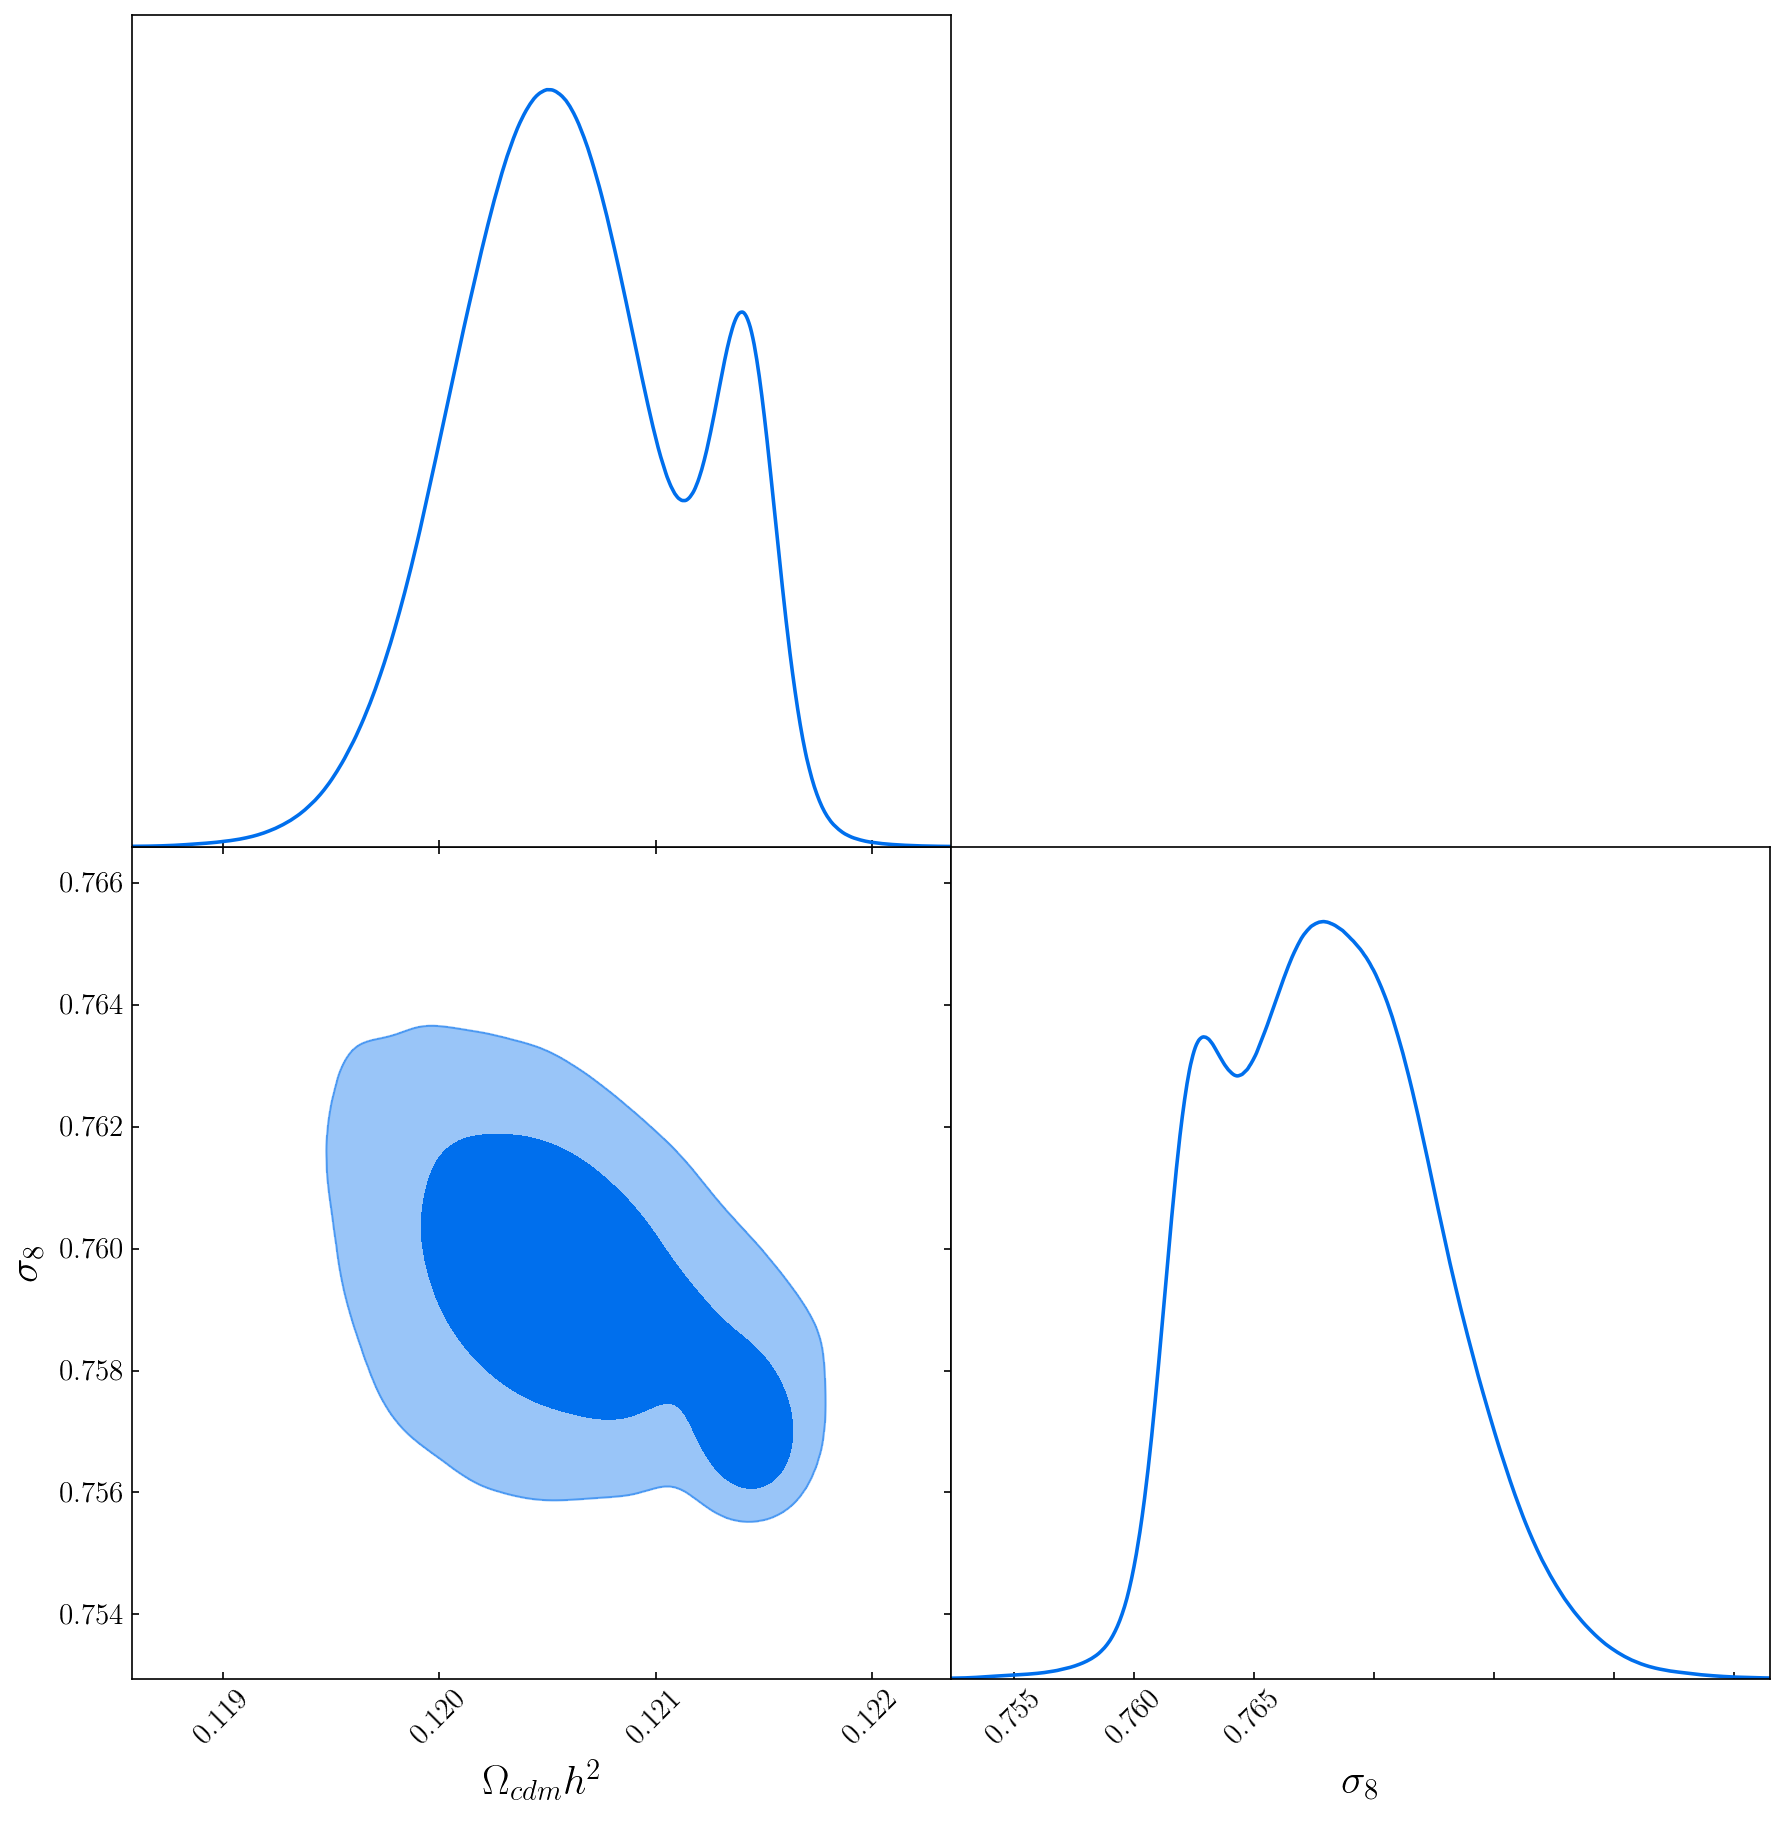

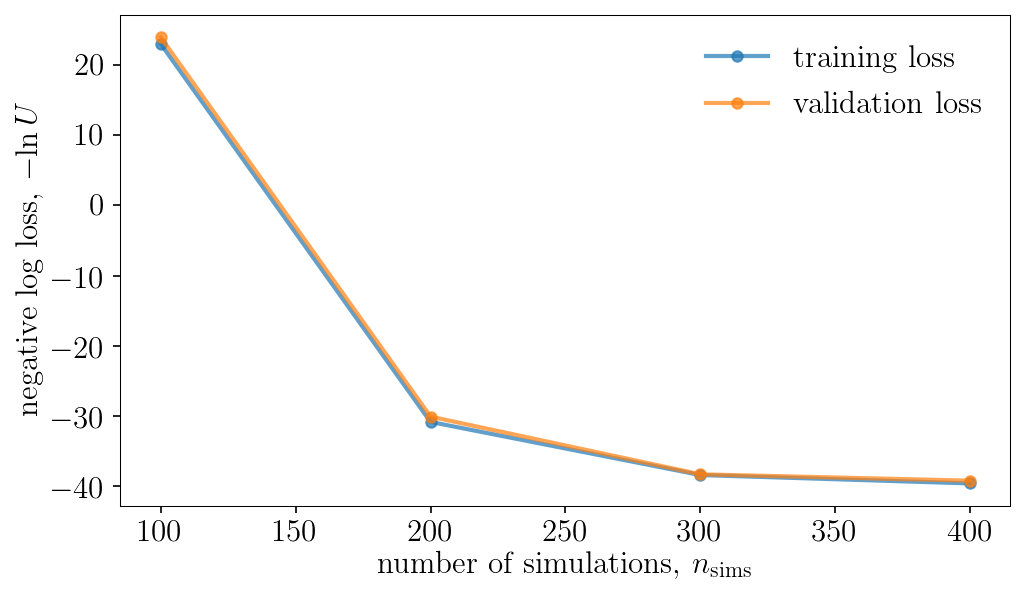

Population 4/10
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


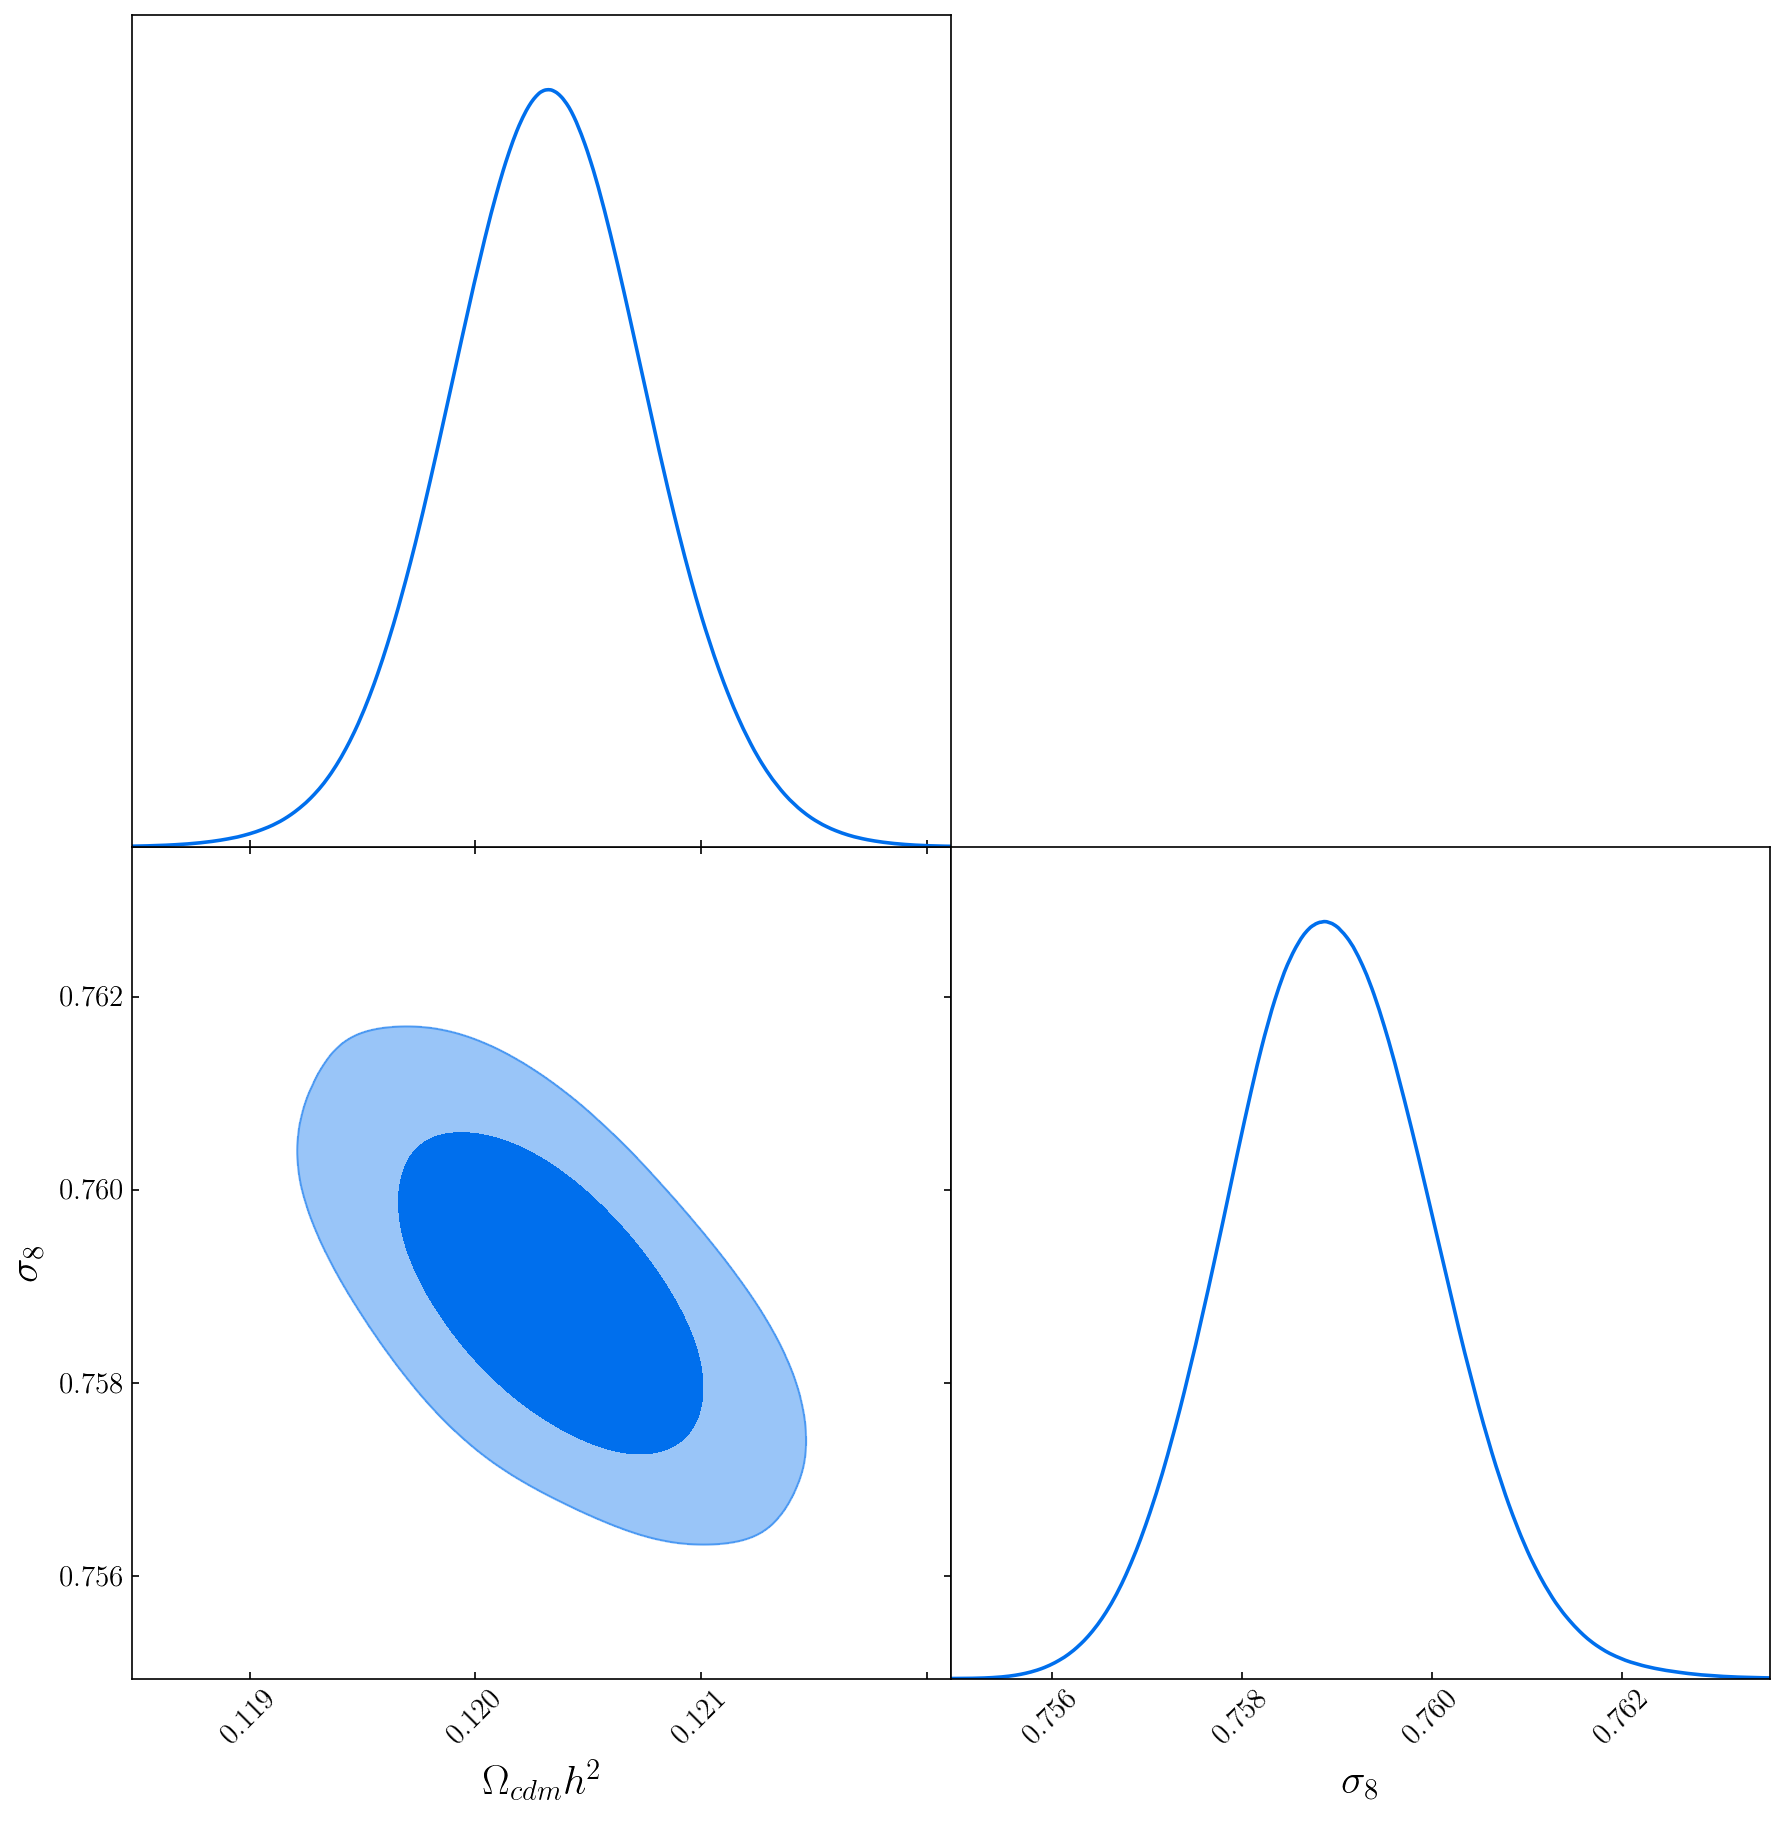

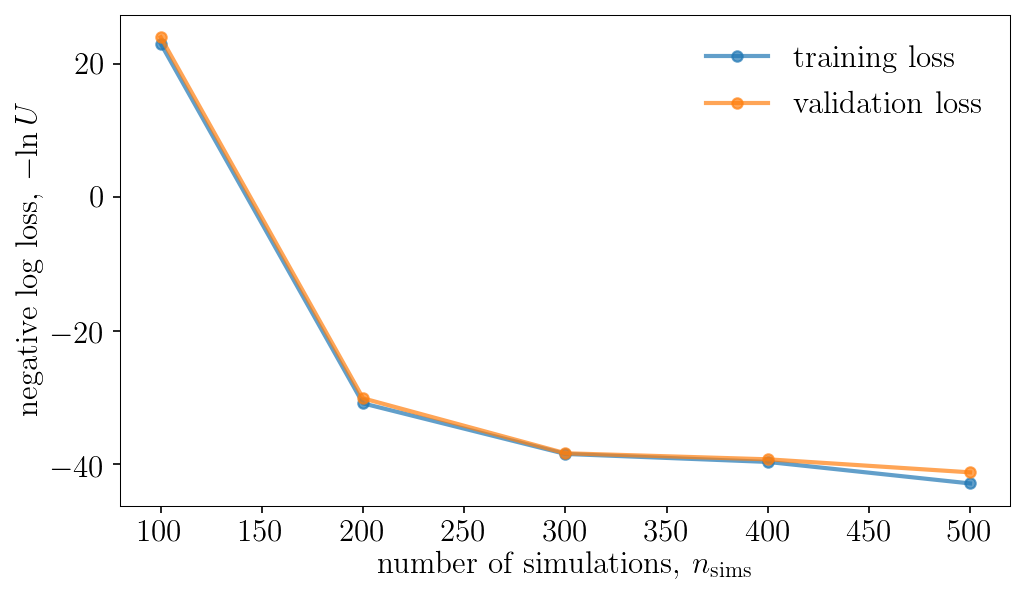

Population 5/10
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


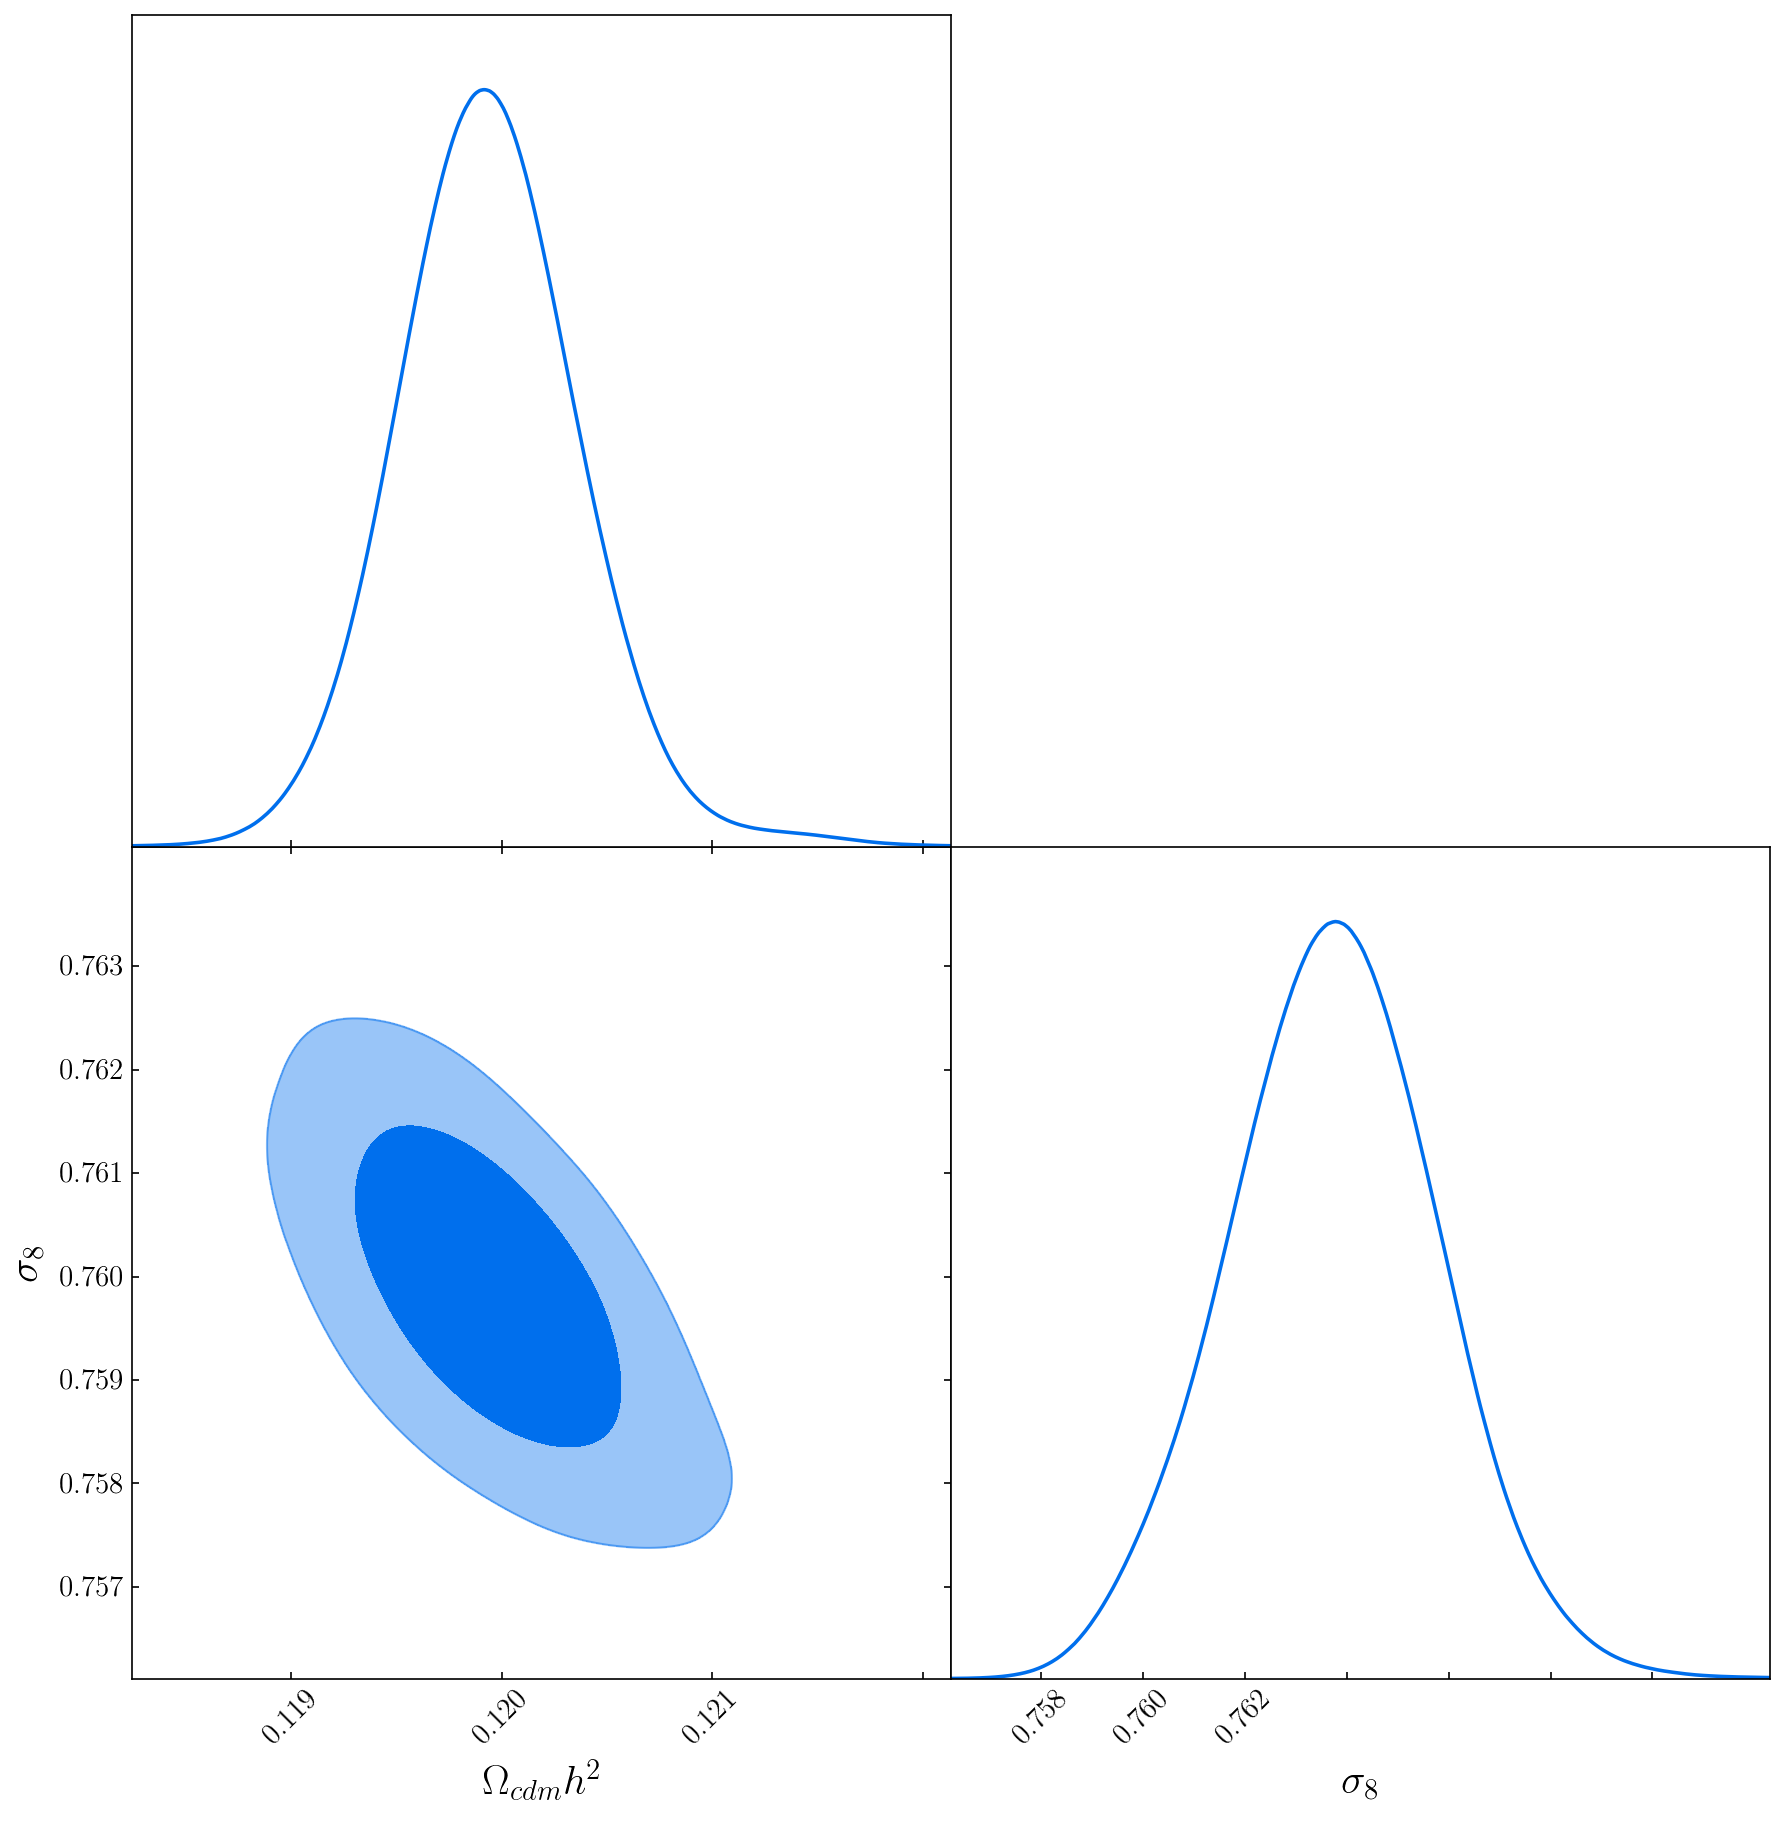

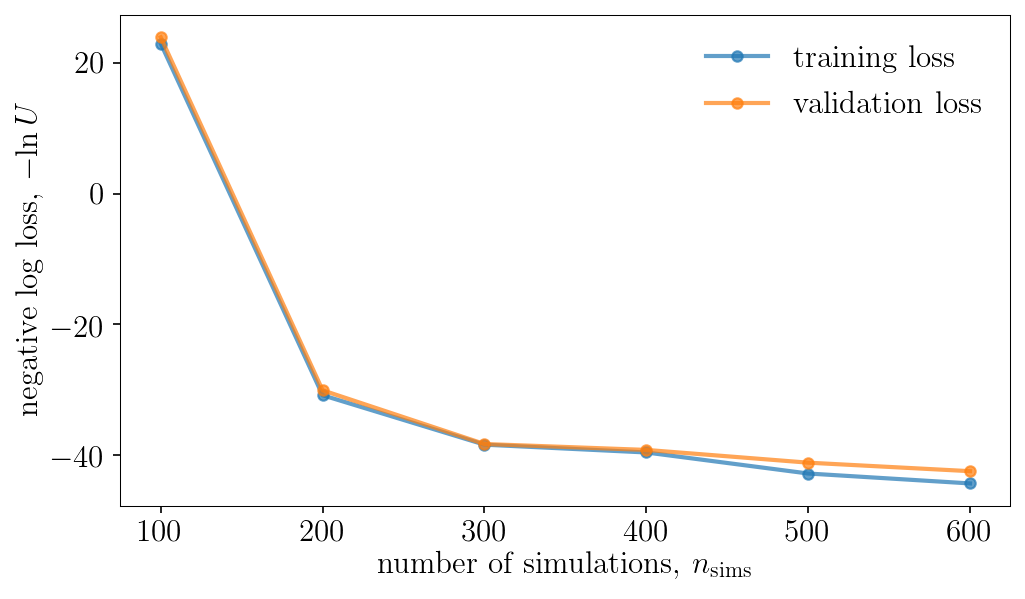

Population 6/10
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


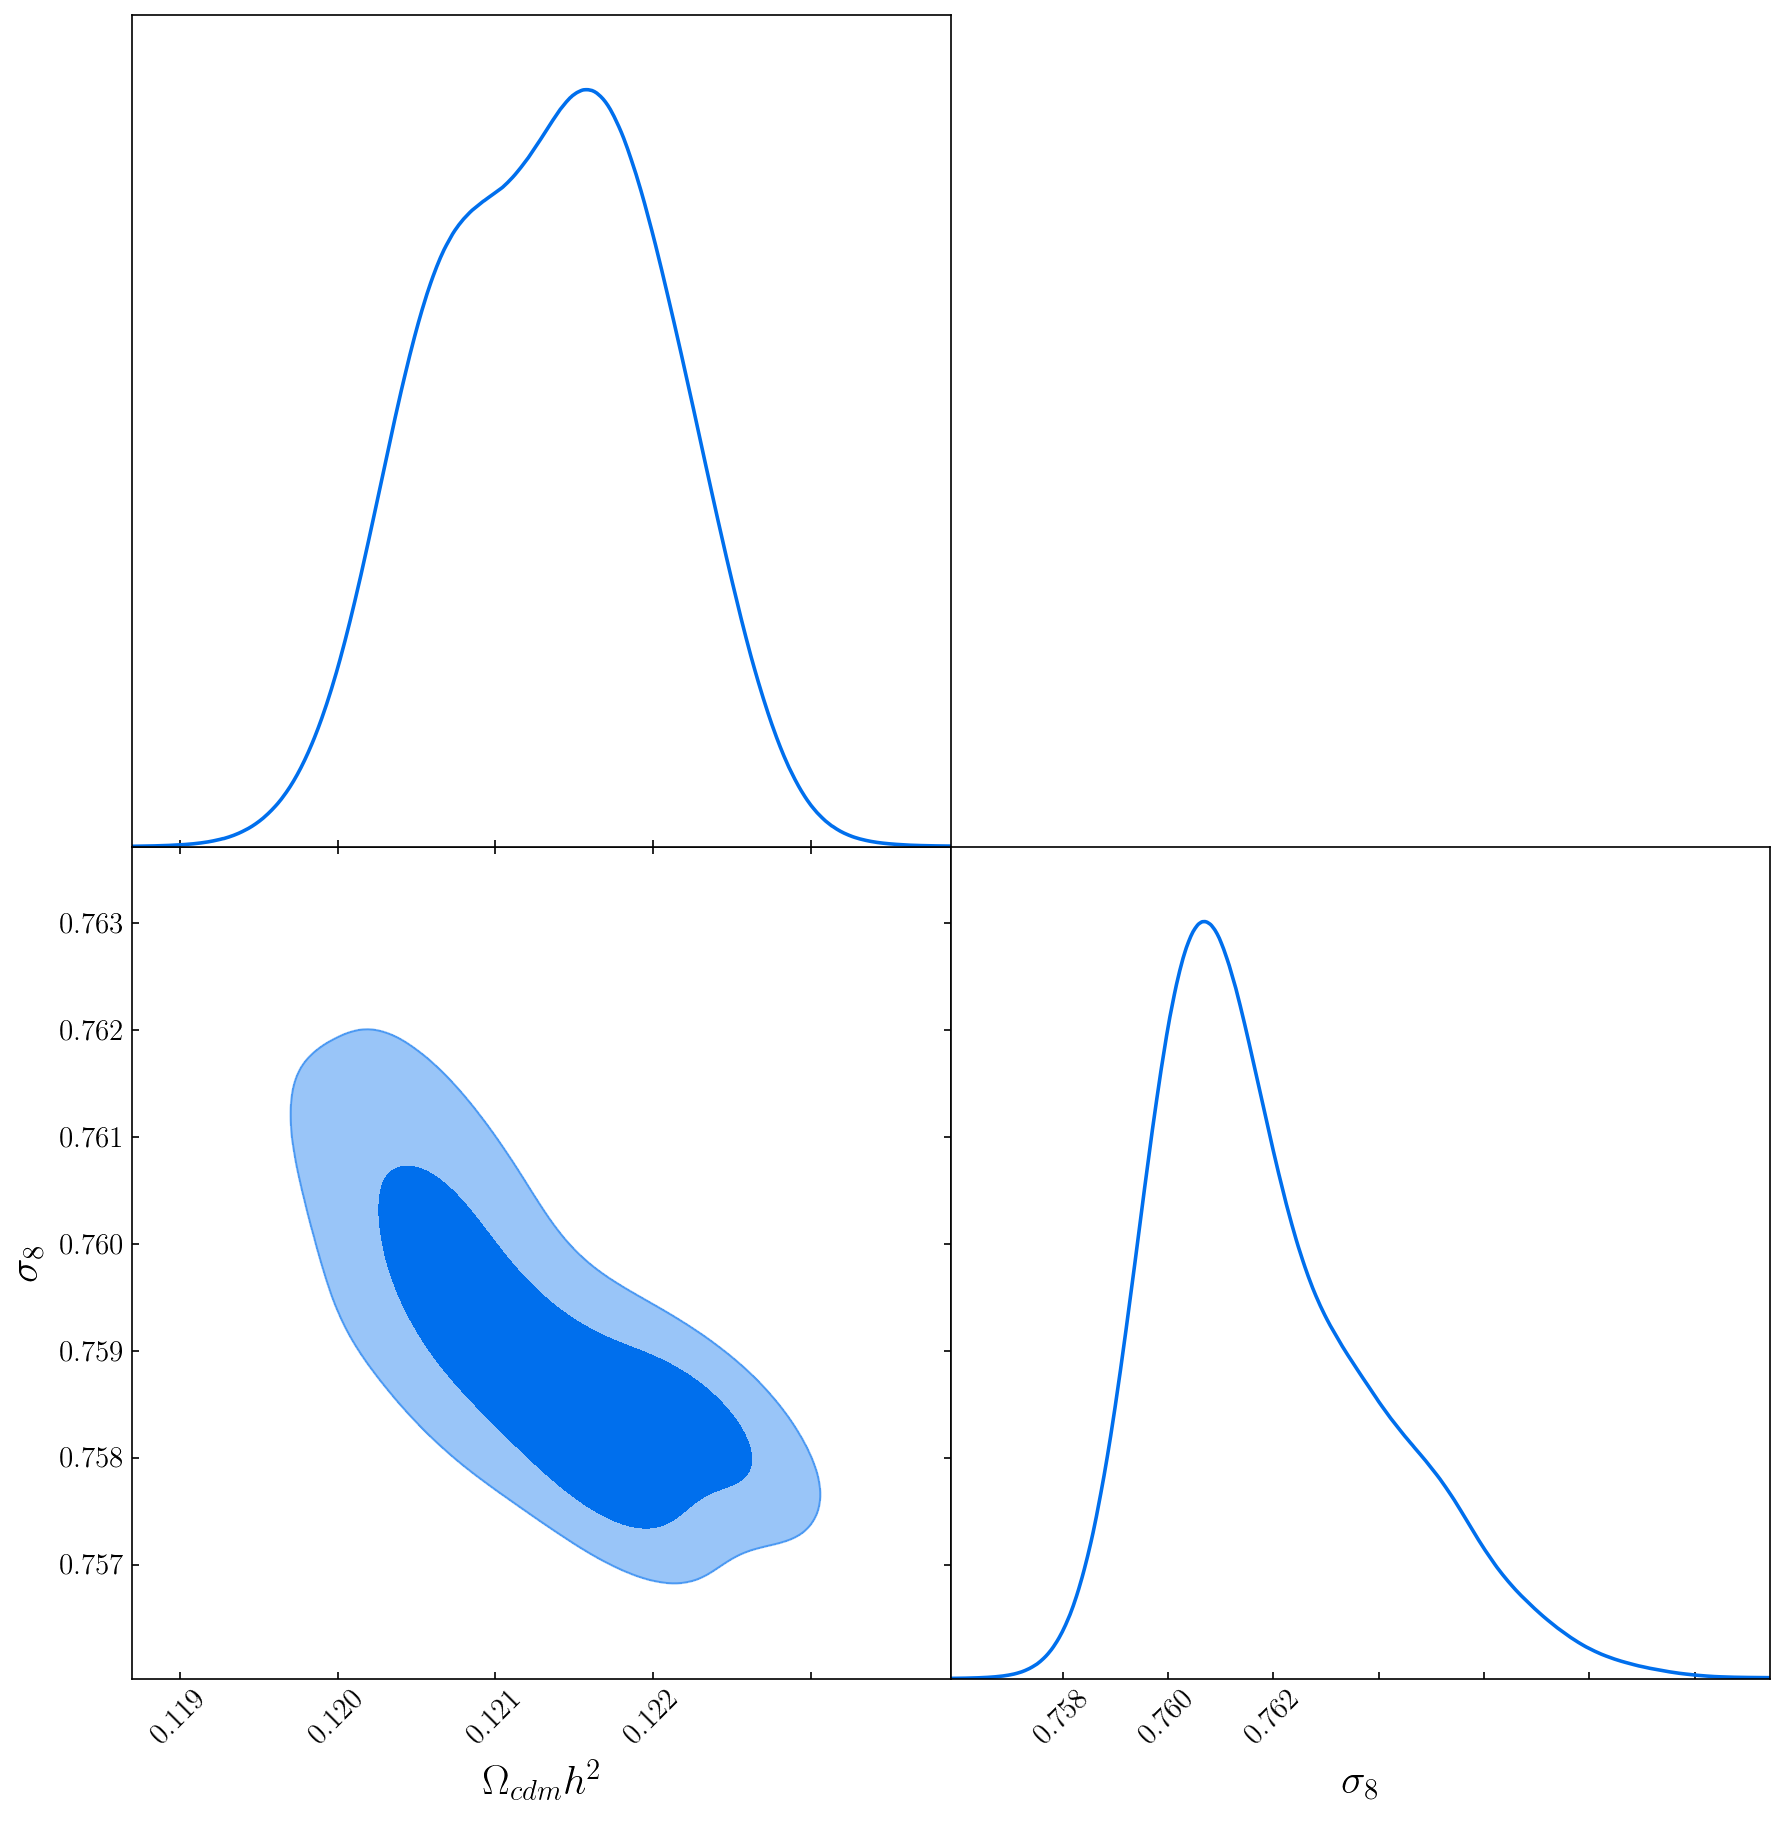

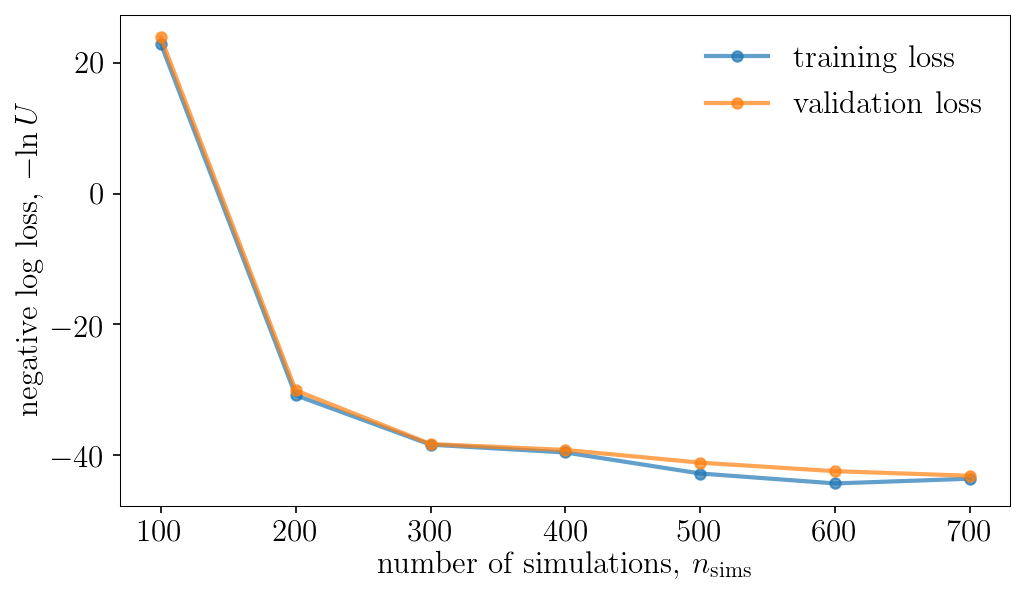

Population 7/10
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


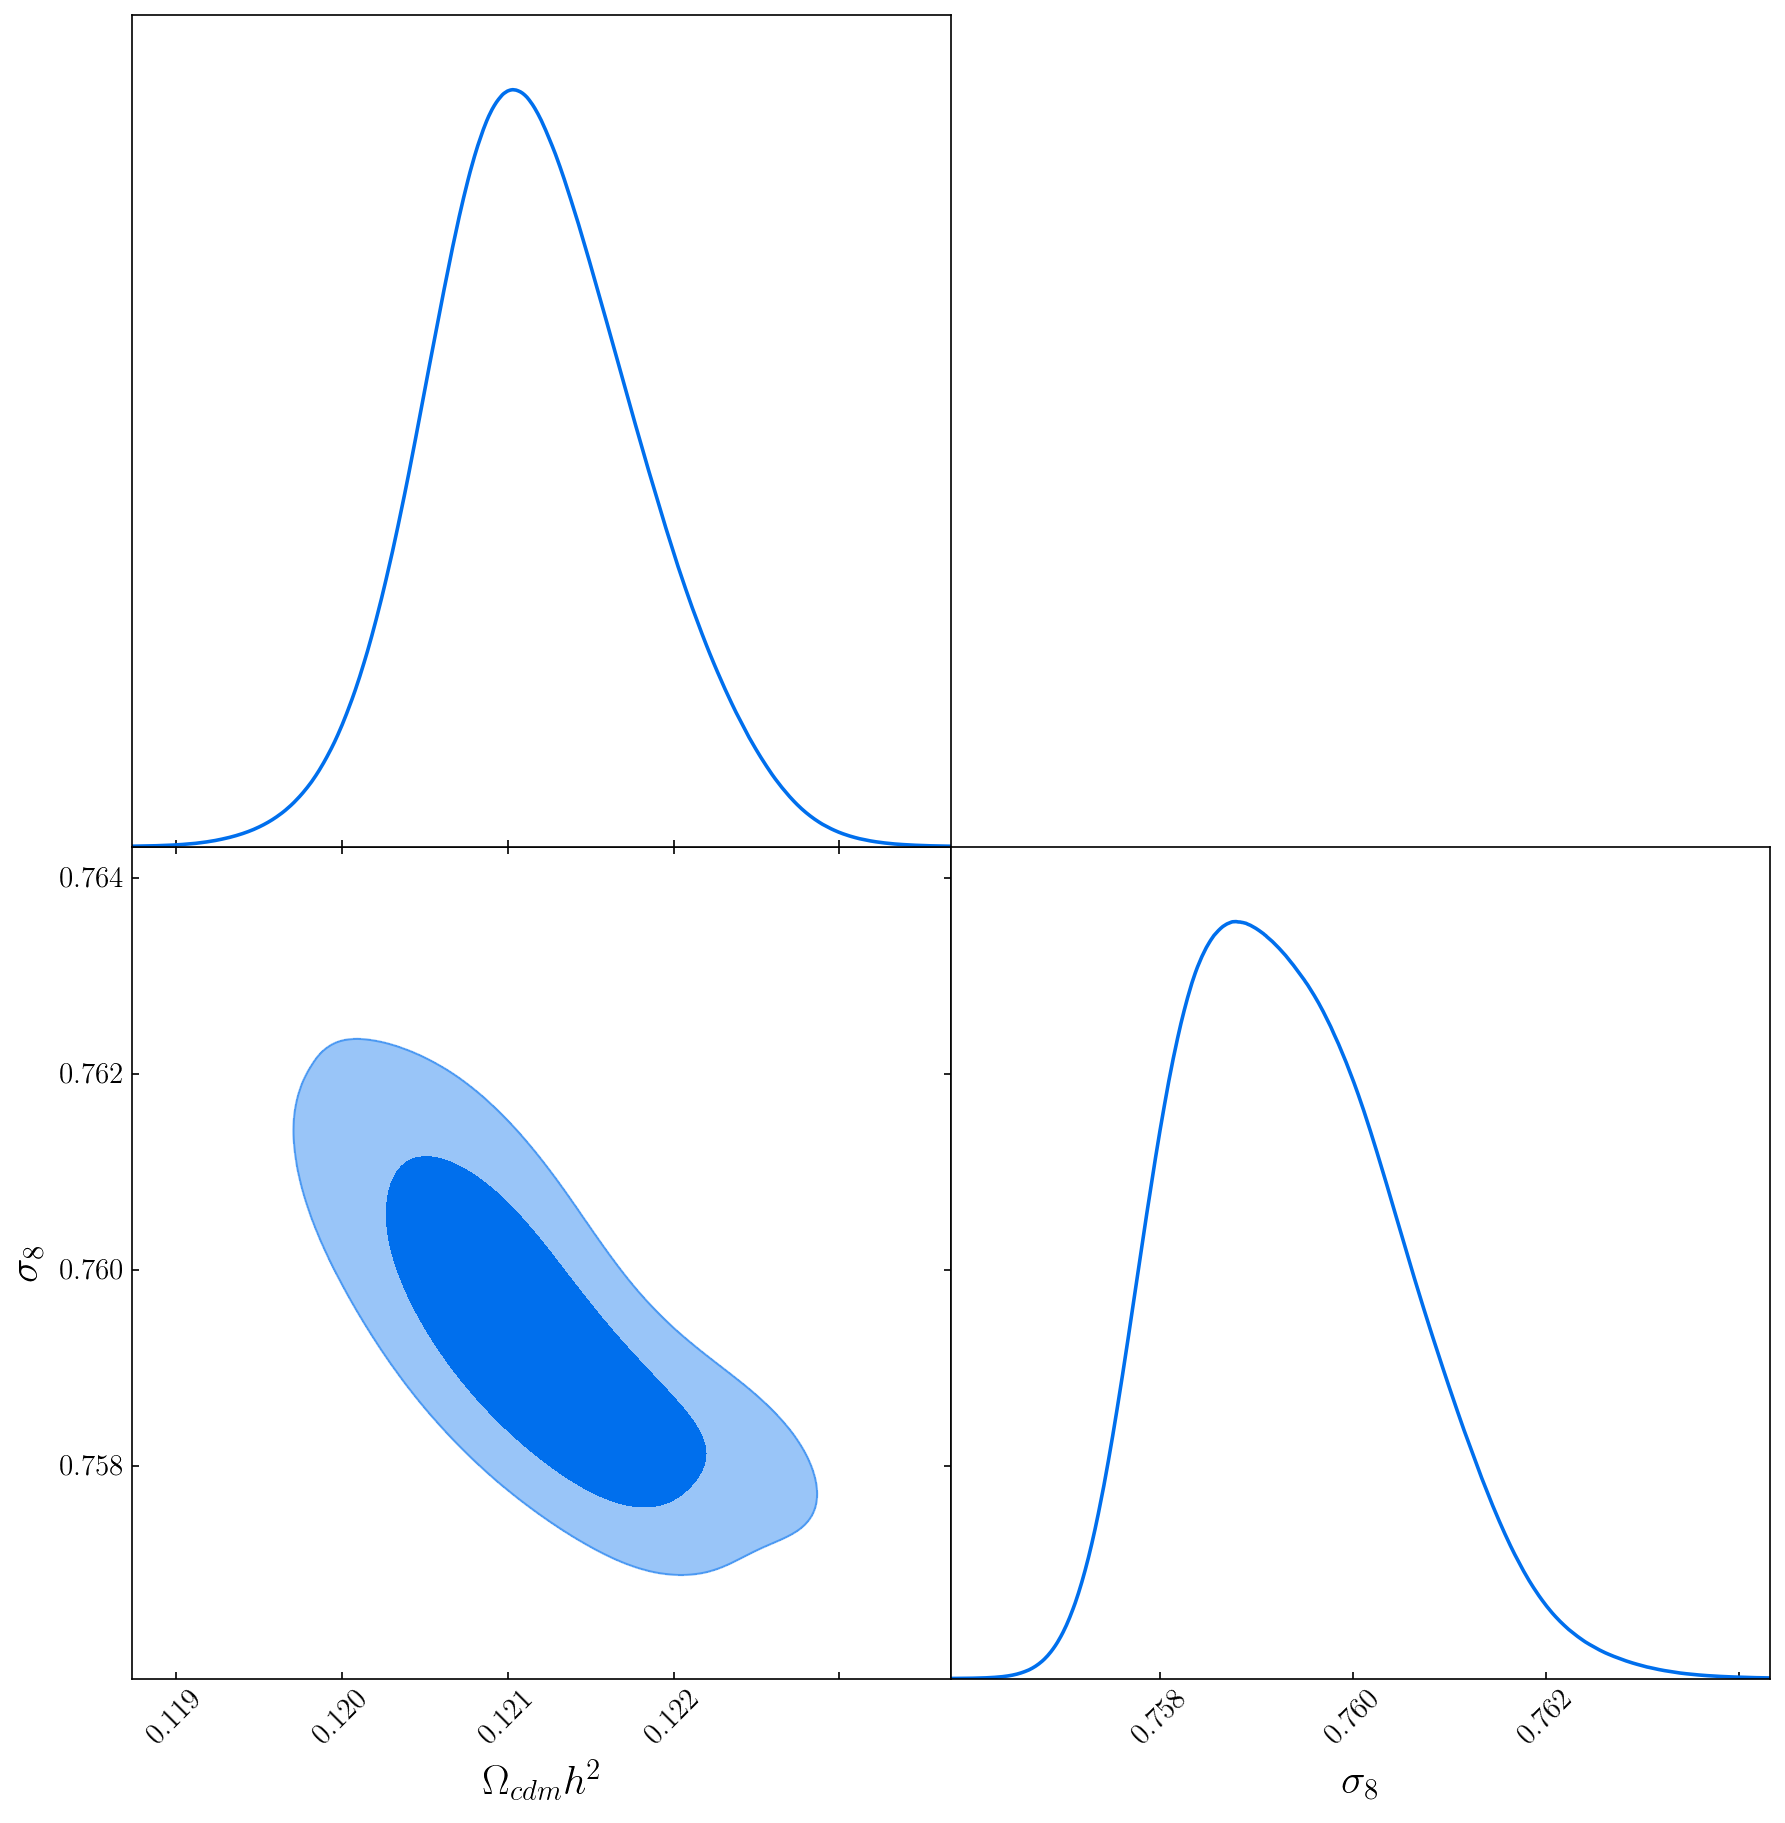

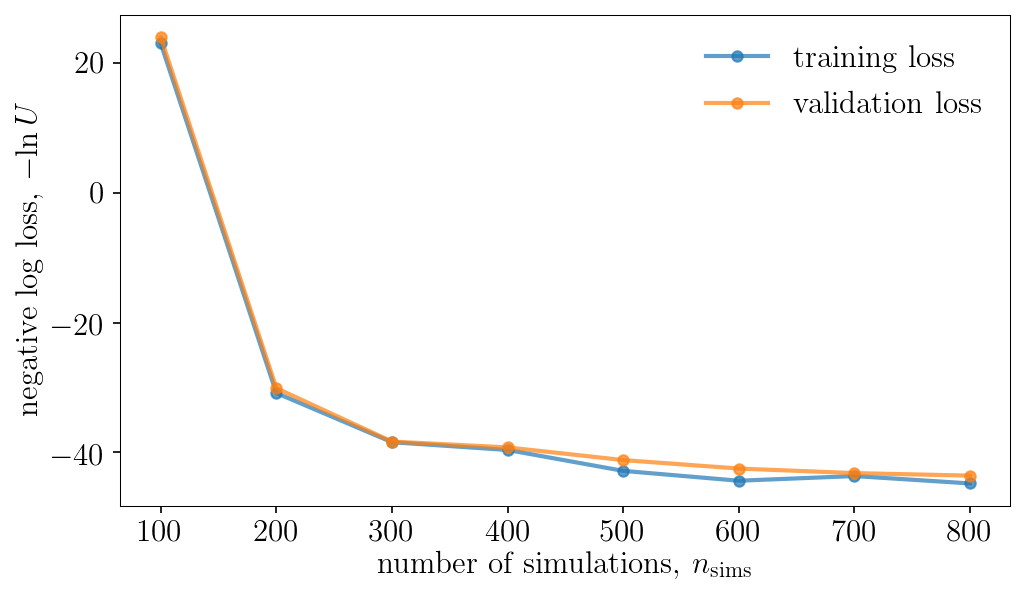

Population 8/10
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


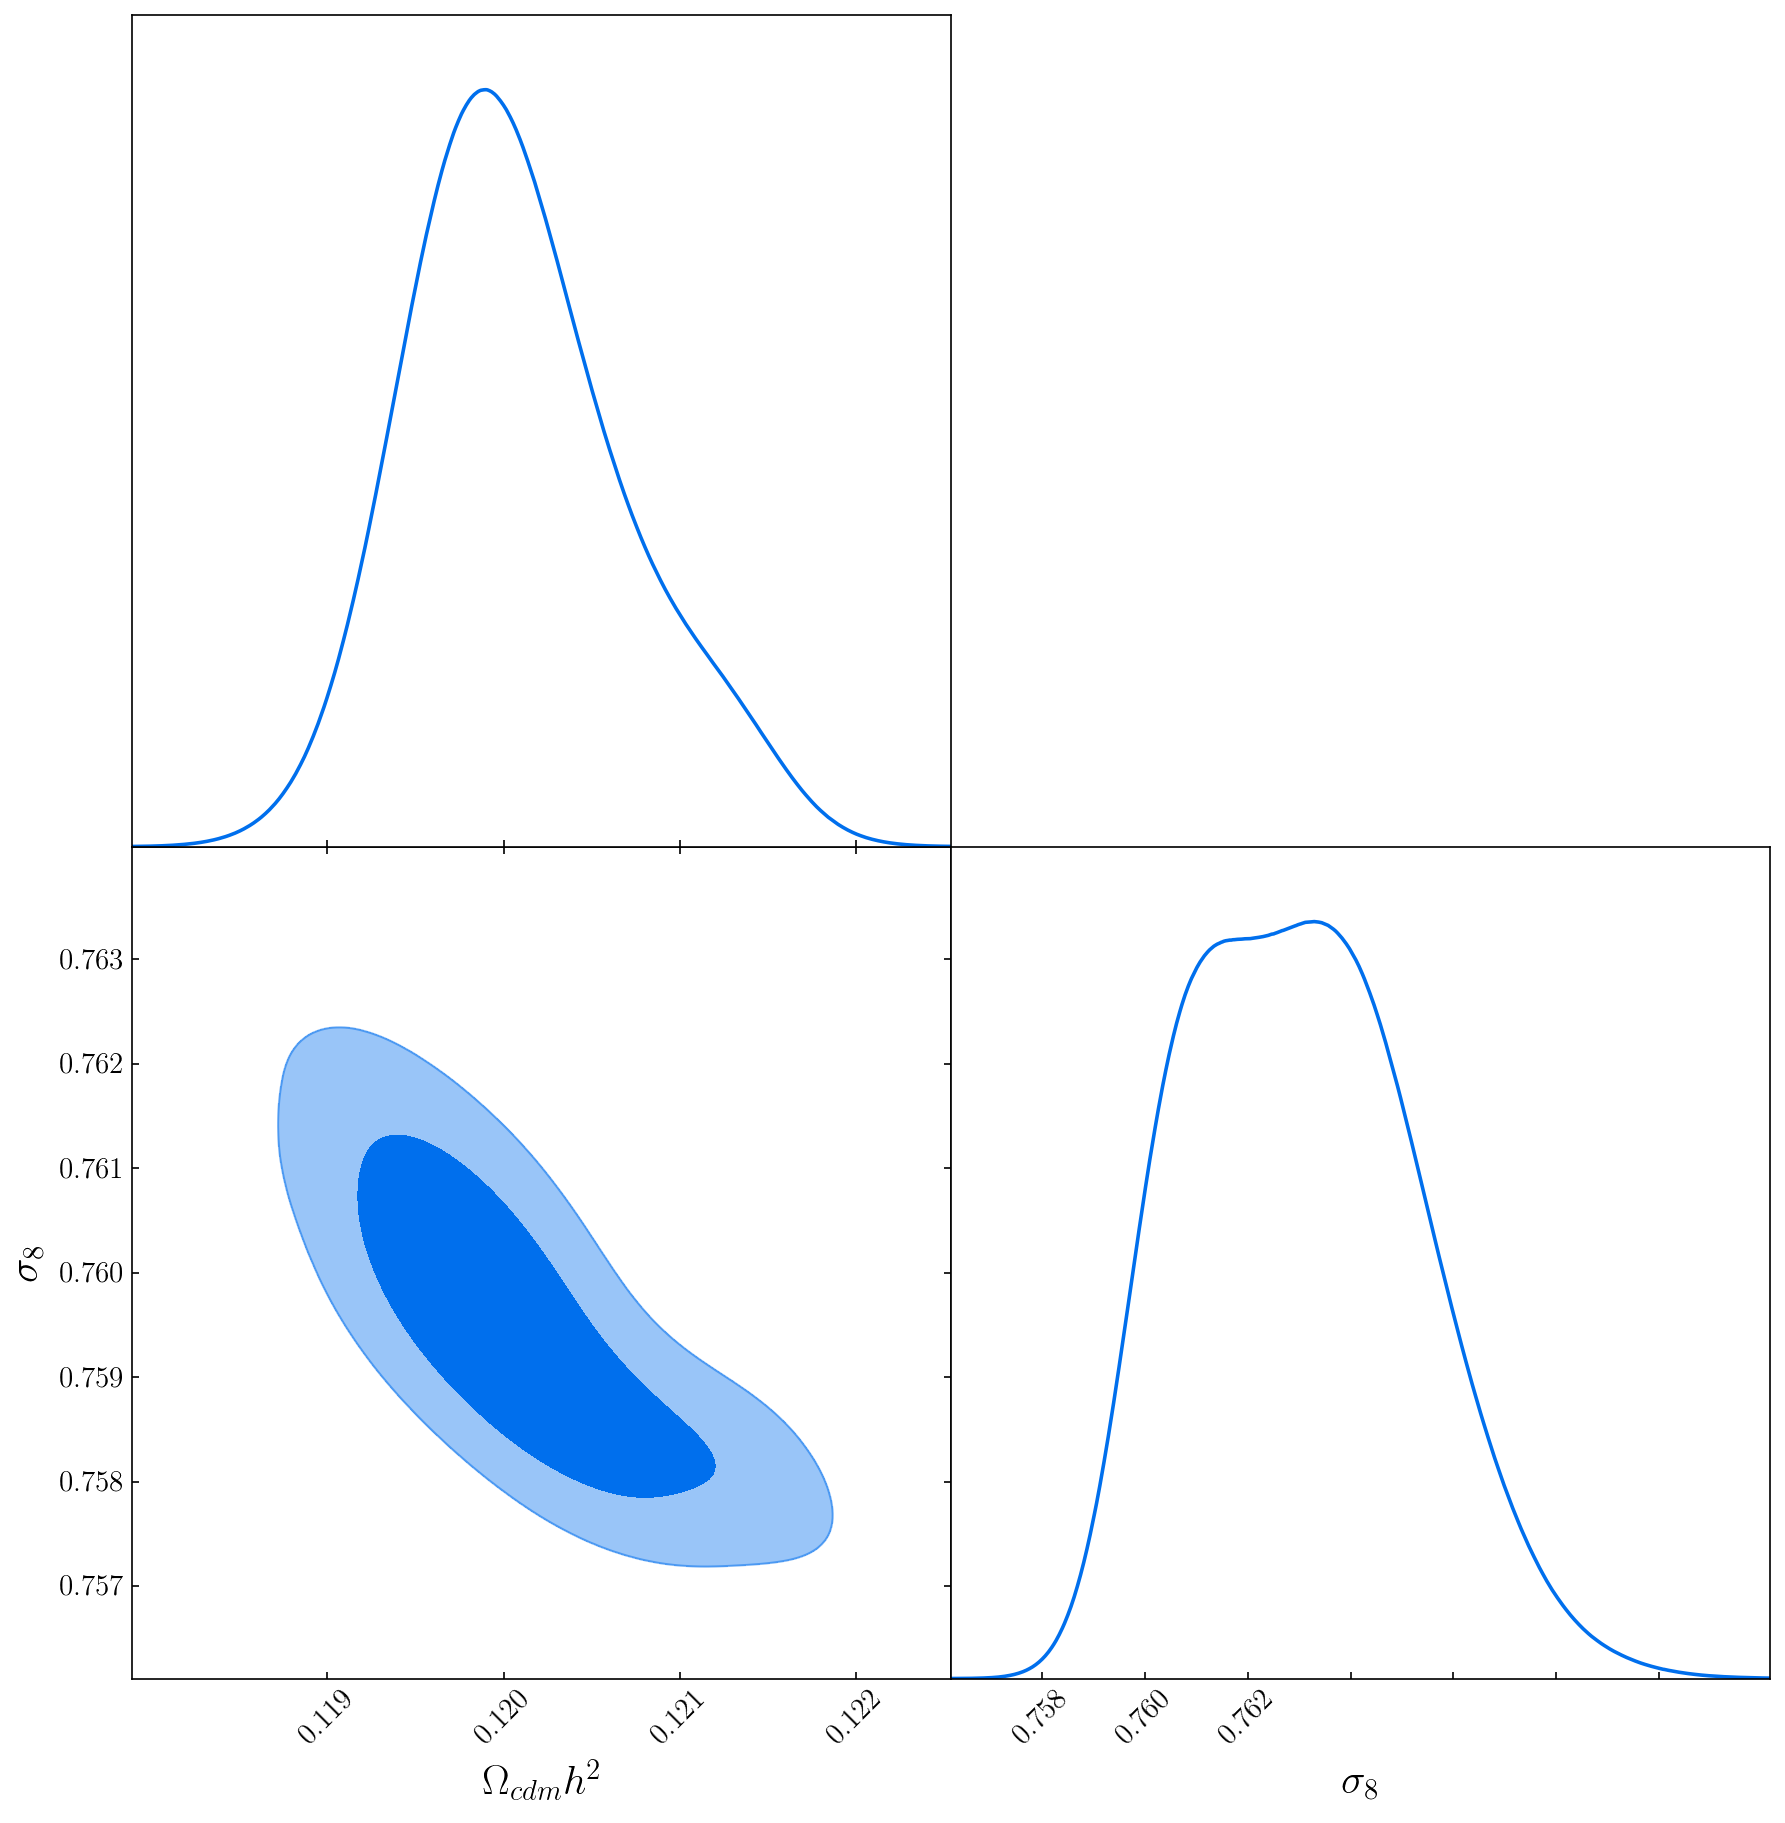

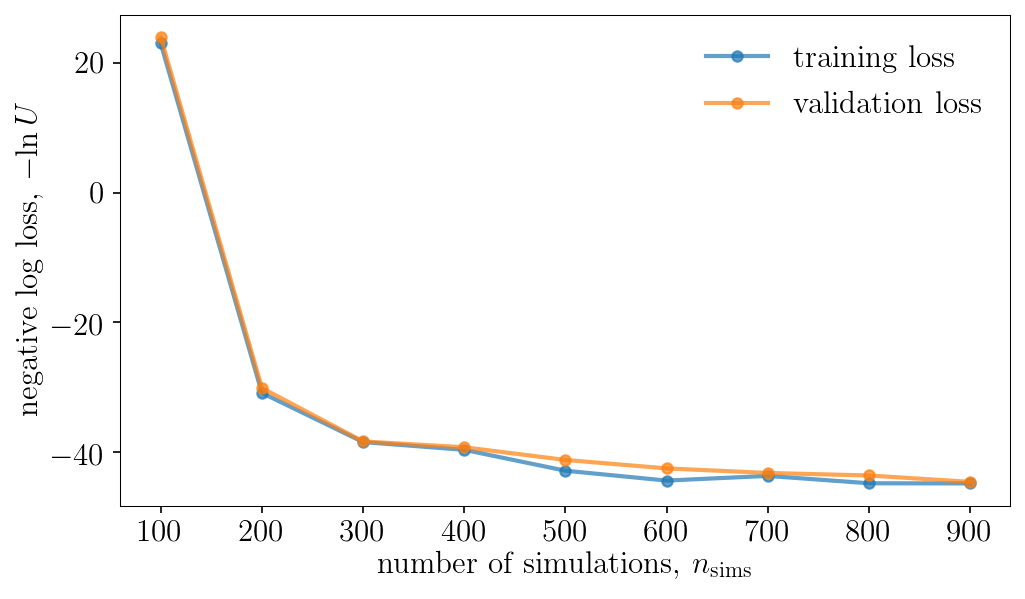

Population 9/10
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


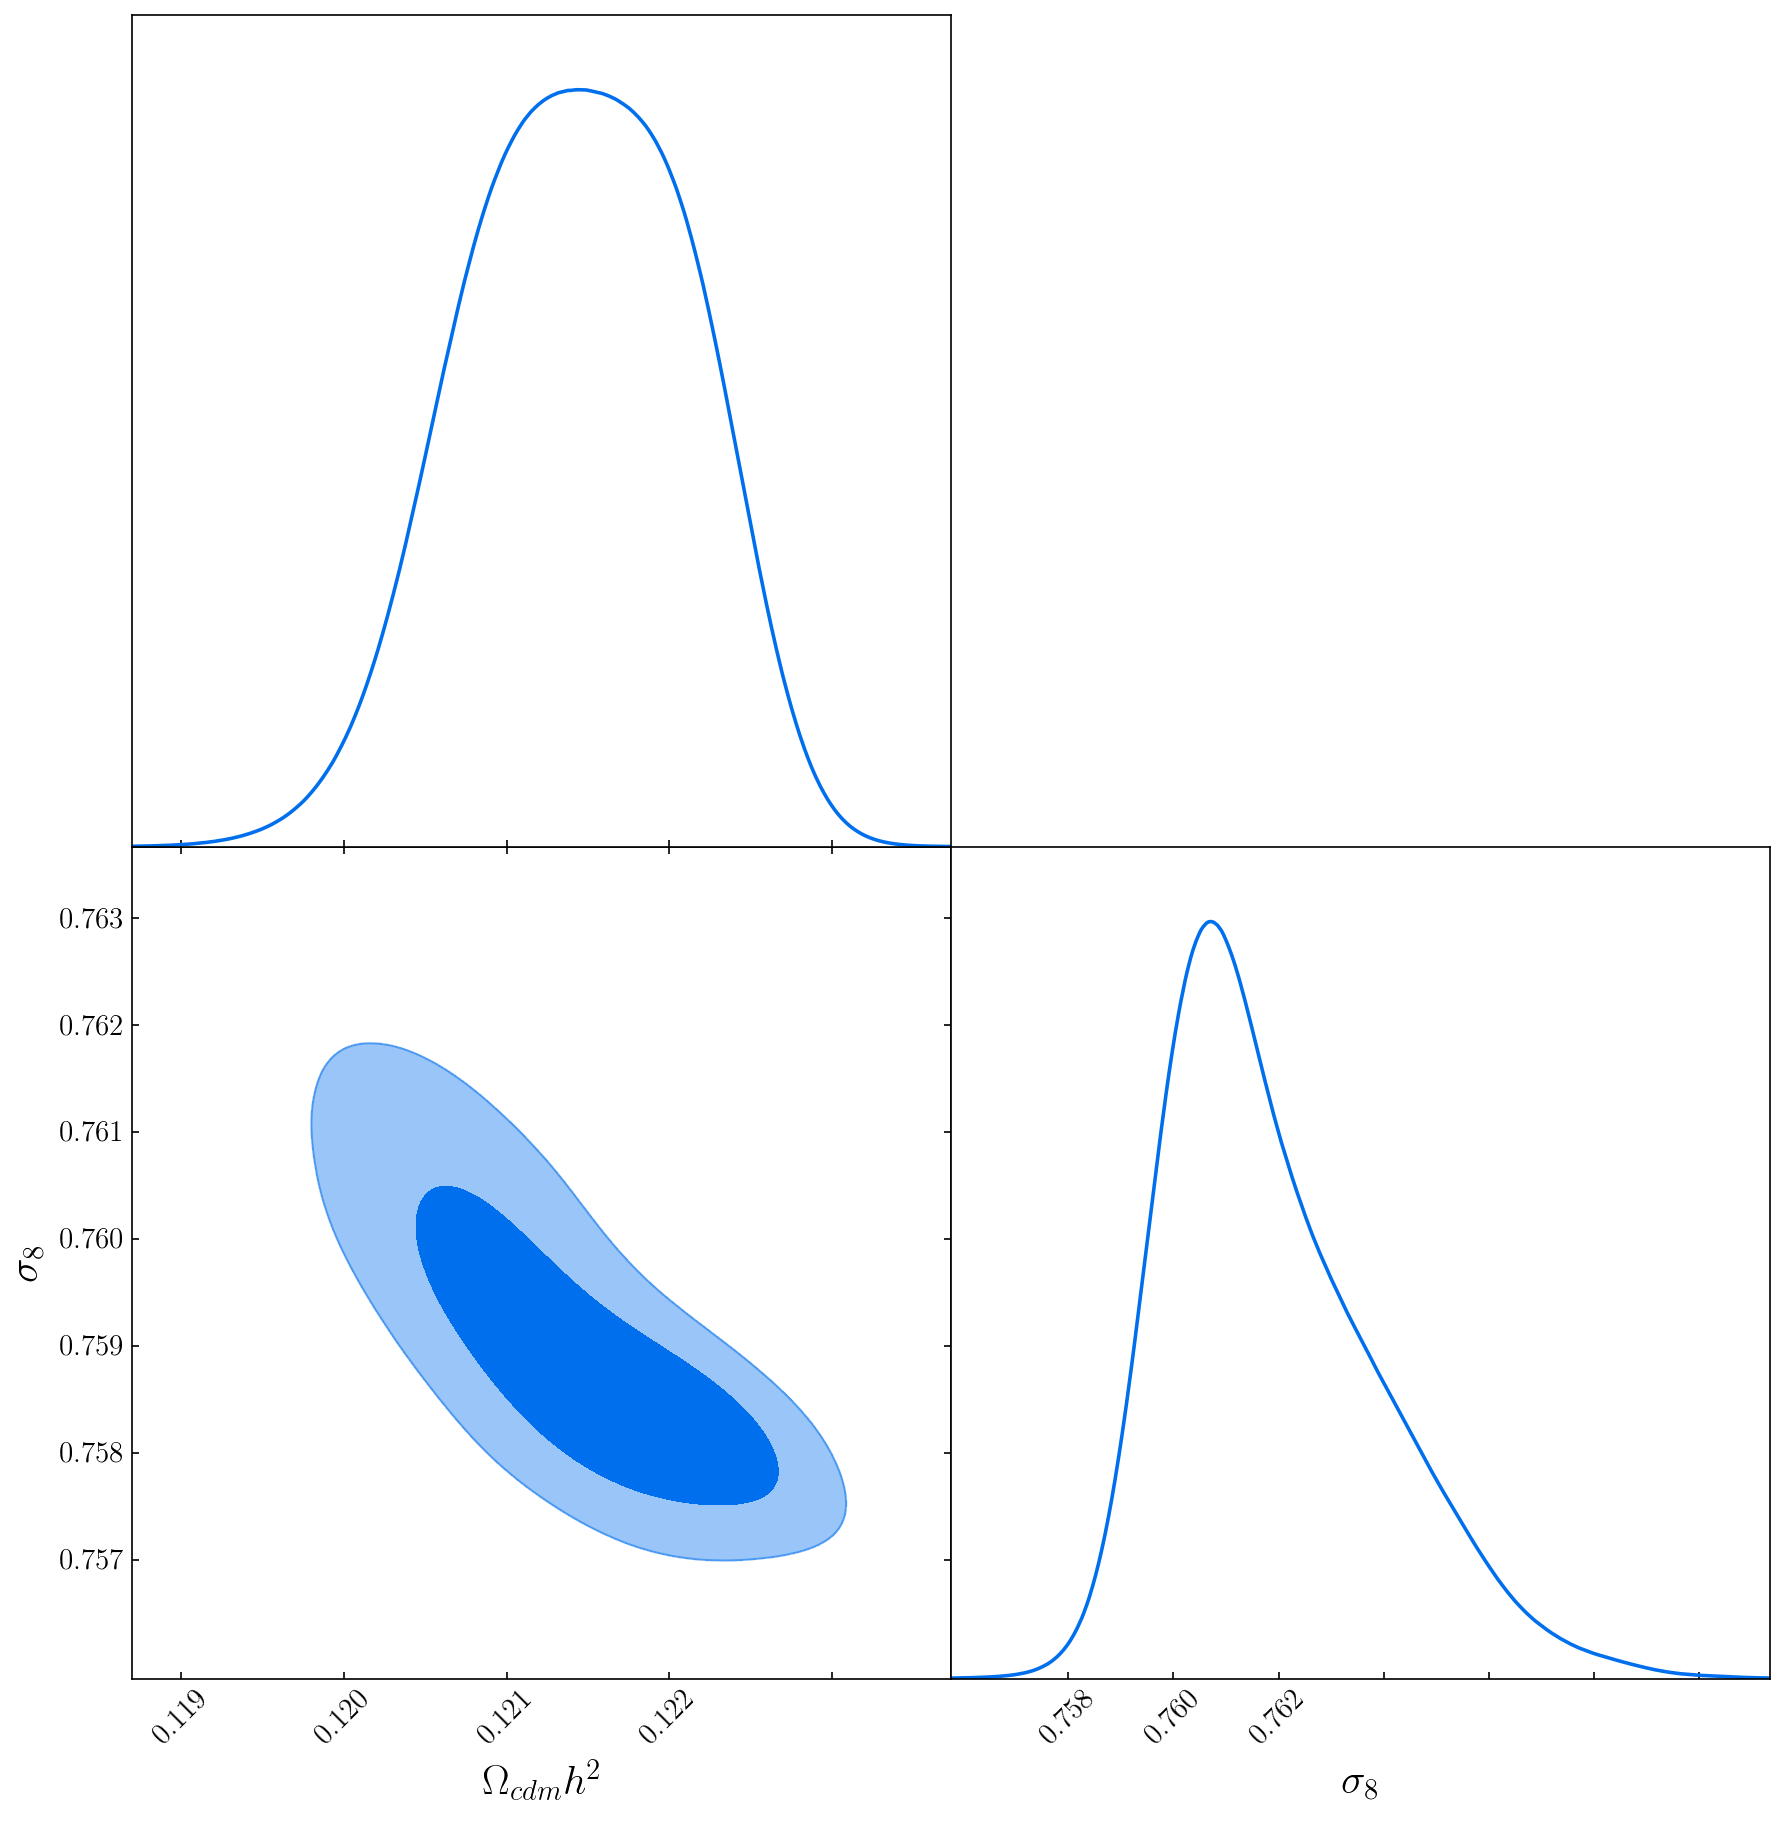

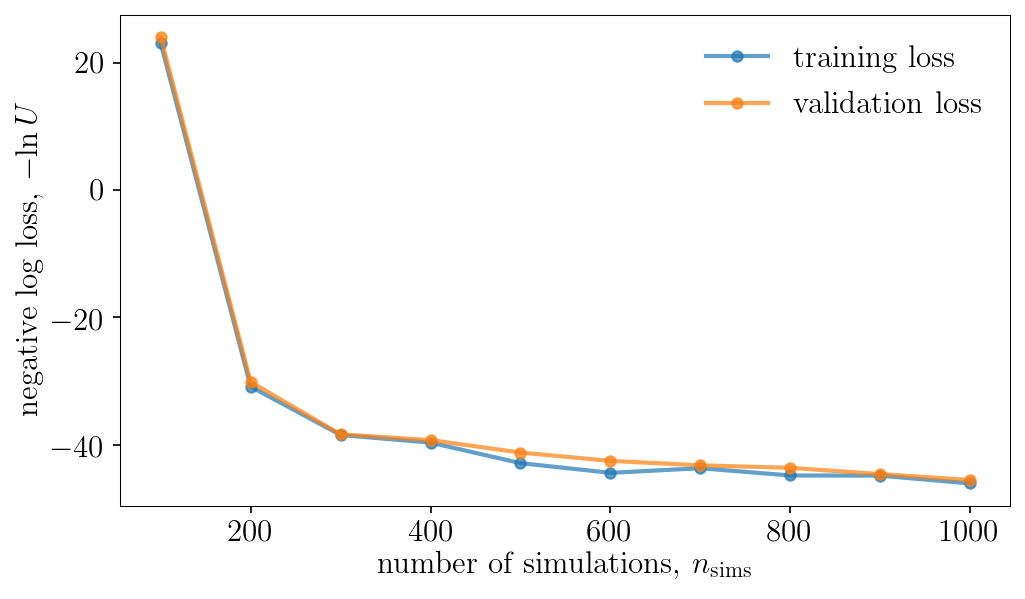

Population 10/10
Sampling proposal density...
Done.


Sampling approximate posterior...
Done.
Removed no burn in


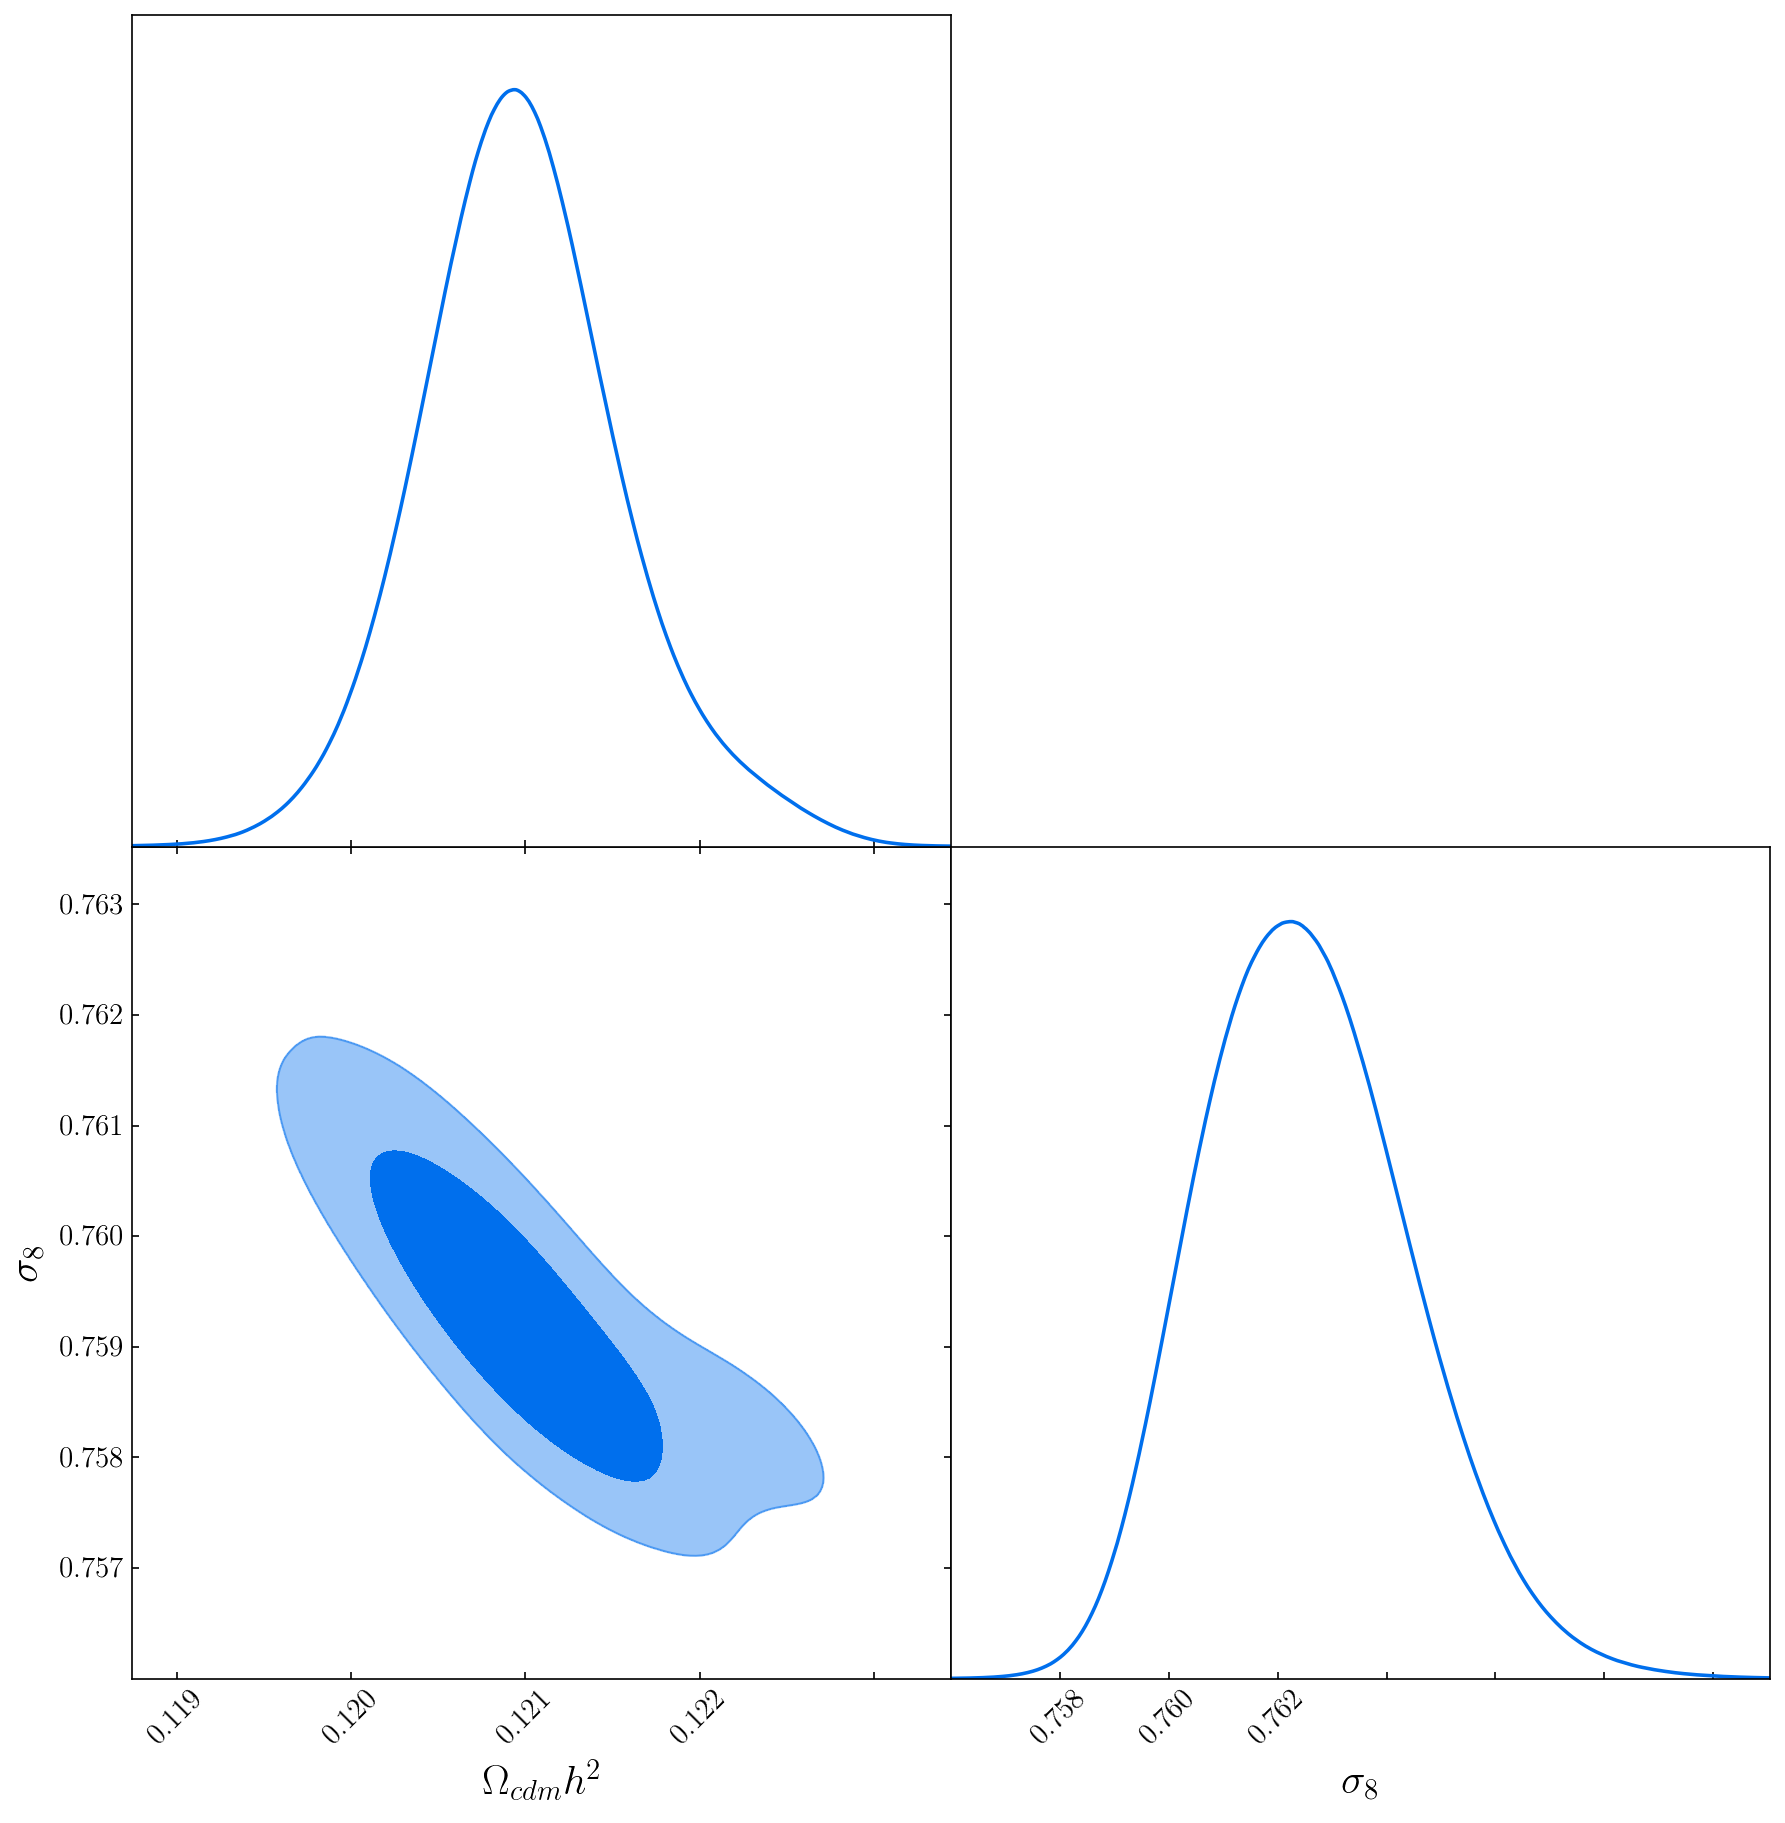

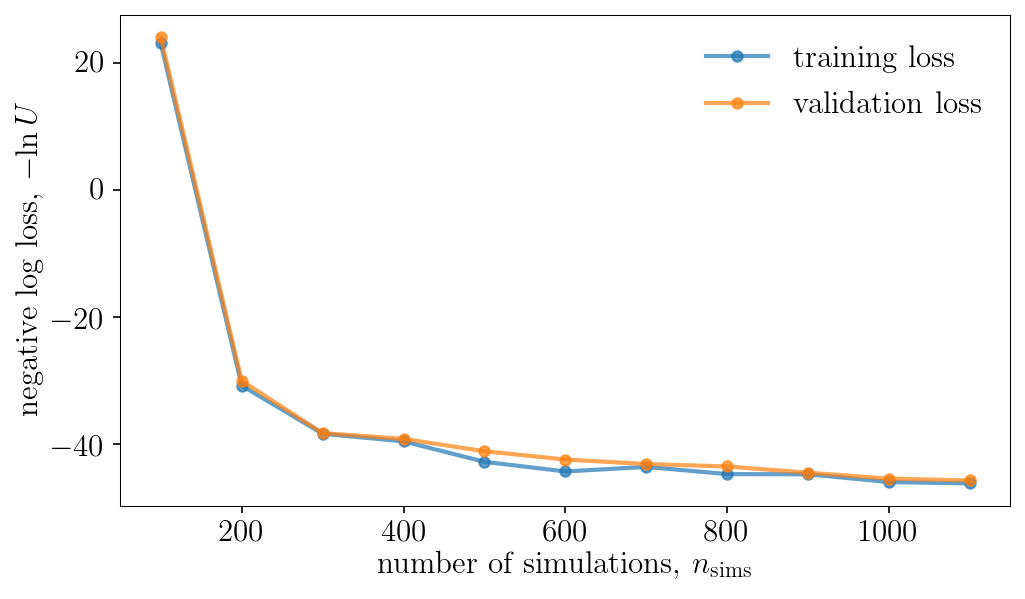

In [33]:
DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, 
                                  save_intermediate_posteriors=True)

## Sample the learned posterior

In [34]:
x0 = DelfiEnsemble.posterior_samples[np.random.choice(np.arange(len(DelfiEnsemble.posterior_samples)), p=DelfiEnsemble.posterior_weights.astype(np.float32)/sum(DelfiEnsemble.posterior_weights), replace=False, size=DelfiEnsemble.nwalkers),:]
posterior_samples, posterior_weights, log_prob = DelfiEnsemble.emcee_sample(x0=x0)

## Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

Removed no burn in


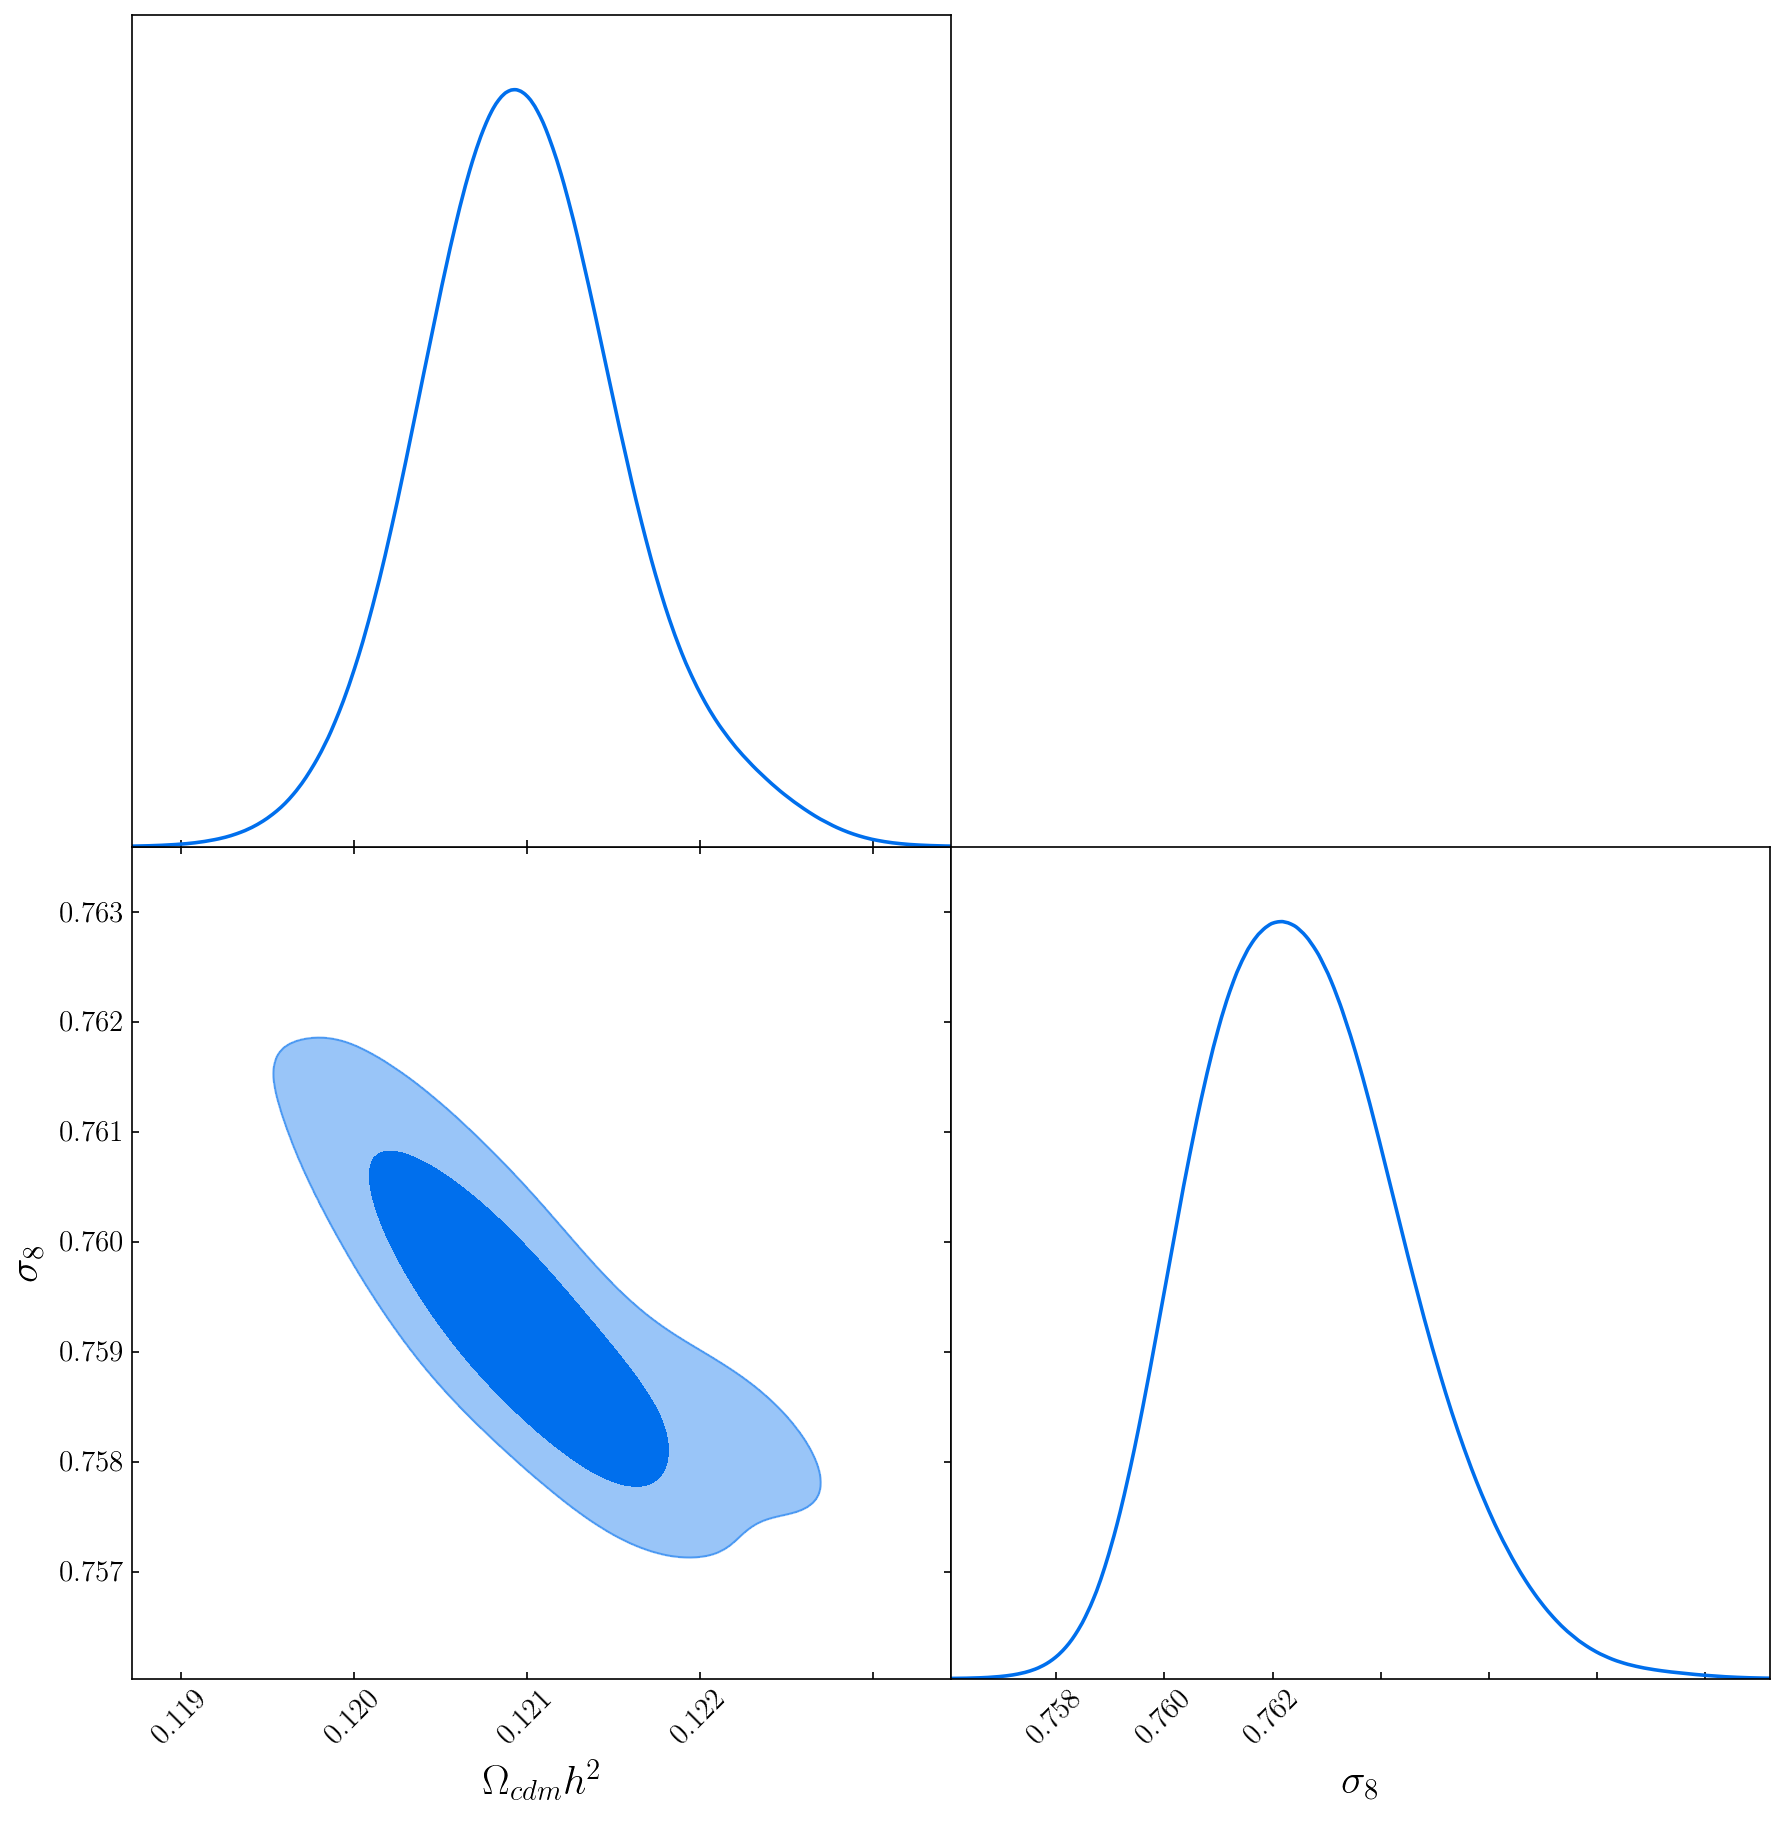

In [35]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples], weights=[posterior_weights])

In [36]:
posterior_samples

array([[0.11740104, 0.76387188],
       [0.11758066, 0.76310495],
       [0.11759216, 0.76283302],
       ...,
       [0.12328282, 0.75837522],
       [0.12400636, 0.75701977],
       [0.12465779, 0.75684635]])

In [38]:
theta_fiducial

array([0.1197, 0.76  ])

In [71]:
def weighted_params(posterior_samples, posterior_weights):
    results_means = np.average(posterior_samples, axis =0, weights = posterior_weights)
    
    # https://stats.stackexchange.com/questions/6534/how-do-i-calculate-a-weighted-standard-deviation-in-excel
    M_nonzero = len(np.nonzero(posterior_weights)[0])
    numerator = np.sum(((posterior_samples - results_means)**2)*posterior_weights.reshape((posterior_samples.shape[0], 1)), axis = 0)
    denominator = (M_nonzero-1)*np.sum(posterior_weights)/M_nonzero
    
    results_stdev = np.sqrt(numerator/denominator)
    
    return results_means, results_stdev

In [74]:
results_means, results_stdev = weighted_params(posterior_samples, posterior_weights)
print(results_means)
print(results_stdev)

[0.11998549 0.75927103]
[0.00060649 0.00097864]


In [86]:
print('Upper and lower 2\sigma-limits:')
print('On \omega_cdm: [' + str((results_means - 2*results_stdev)[0]) + ', ' + str((results_means + 2*results_stdev)[0]), ']')
print('On \sigma_8: [' + str((results_means - 2*results_stdev)[1]) + ', ' + str((results_means + 2*results_stdev)[1]), ']')

Upper and lower 2\sigma-limits:
On \omega_cdm: [0.11877251674057439, 0.12119847292103299 ]
On \sigma_8: [0.7573137516794263, 0.7612282994460319 ]
